In [178]:
# ! pip install statsmodels==0.14.0

In [179]:
run = 0

In [180]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_context('talk')

In [181]:
model = 'roberta-base'

In [182]:
constructs = ['sexism', 'hatespeech']

reverse_label_encode = {'sexism' : {1 : 'sexist', 0 : 'non-sexist'},
                        'hatespeech' : {1 : 'hate', 0 : 'not hate'}
                       }
            
label_encode = {'hatespeech': {'hate' : 1, 'not hate': 0},
                    'sexism' : {'sexist' : 1, 'non-sexist': 0}
                   }

In [183]:
with open('../results/intermediate/paired_cads_mixed_rq2_properties.pickle', 'rb') as handle:
    paired_data = pickle.load(handle)

In [184]:
for construct in constructs:
    paired_data[construct] = pd.read_csv('../results/intermediate/%s_paired_cads_mixed_rq2_properties_ed.csv' %construct)

We will use v-information to score instances in the dev and test sets. We will make two training sets (+ dev sets):
- one with CADs
- one without CADs

Three test set sets:
- one with ID data (without CADs)
- one with ID + CADs
- one with OOD data (mixed from all)

We have the following hypothesis:
- h3.1: the dev set with CAD and the OOD test set is harder for training model without CADs
- h3.2: in the cad dev set + test set, 
    - shorter CAD have higher v info
    - more similar CAD have higher v-info
    - construct-driven CAD have higher v-info

### make training data

In [185]:
sample_data = pd.read_csv('../../dataset_difficulty/data/dwmw_std.csv')
sample_data.head()

,Unnamed: 0,Unnamed: 0.1,count,hate_speech,offensive_language,neither,label,sentence1
0,0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


all the datasets need to have the following columns:
- id
- sentence1 (text)
- label
- cad or not
- cad type
- cad length
- cad similarity
- edit type

In [186]:
paired_data['sexism'][['original_id', 'original_text', 'original_label',
                       'mixed_cad_text', 'mixed_cad_label', 'mixed_cad_type']]

,original_id,original_text,original_label,mixed_cad_text,mixed_cad_label,mixed_cad_type
0,5d654923ce2c6bd733479214,Hayi fuck it nyaniRT @ClixWell: Women's 7s rugby? fuck this shit.,sexist,Hayi fuck it nyaniRT @ClixWell: Minor League 7s rugby? fuck this shit.,non-sexist,counterfactual
1,5d65490bce2c6bd73347666e,@Spacekatgal the client/web experience being similar are key. i don't know if twitter client has the additional controls verified accts have,non-sexist,NaN,NMAR,flant5
2,5d654922ce2c6bd733478f3e,when my man is hungry I'm making him the best damn sandwich he's ever tasted,sexist,"When my partner is hungry, I'm making them the best damn sandwich they've ever tasted.",non-sexist,chatgpt
3,5d654904ce2c6bd733475e10,"“There is no limit to what we, as women, can accomplish.” —Michelle Obama. Happy #WomensDay ! https://t.co/PRg9ozxg7S",non-sexist,"""There is no limit to what we, as men, can accomplish."" —Michelle Obama. Happy #MensDay! https://t.co/PRg9ozxg7S",NMAR,chatgpt
4,5d654921ce2c6bd733478cce,.@ainsleyearhardt you looked beautiful in the deep blue/purple dress you wore today. What a knock out. Found your color?,non-sexist,.@ainsleyearhardt you looked fabulous in the deep blue/purple dress you wore today. What a knock out. Found your color?,NMAR,polyjuice
...,...,...,...,...,...,...
2849,5d654920ce2c6bd7334788b0,"im kinda skeptical about these Kelis in the face,$50k a month on ""child"" support ass hoes yall look up 2.",sexist,I find it odd when girls have ugly handwriting. I find it weird when boys have beautiful handwriting.,non-sexist,flant5
2850,5d654922ce2c6bd733478d6a,RT @AmyOscar: I love a man who does the dishes. #JustSayin> it ain't sexist AND why shouldn't they?,non-sexist,"I love a man who does the dishes. #JustSayin> It's amazing that a man can do something as menial as dishes, but I guess it's better than nothing.",NMAR,chatgpt
2851,5d654921ce2c6bd733478a78,I just saw a woman masterfully parallel park that’s a first for me https://t.co/NdC8j0aqv3,sexist,NaN,MAR,counterfactual
2852,5d654923ce2c6bd73347923c,"----> RT @Hello_Brittanyy: women should never be ""bored"". There's ALWAYS some shit to clean or something to be cooked.",sexist,"----> RT @Hello_Brittanyy: grownups should never be ""bored"". There's ALWAYS some shit to clean or something to be cooked.",non-sexist,counterfactual


In [187]:
# for construct in constructs:
#     print(construct, len(paired_data[construct]))
#     paired_data[construct] = paired_data[construct][paired_data[construct]['counterfactual_label'] != 'MAR']
#     paired_data[construct] = paired_data[construct][paired_data[construct]['chatgpt_label'] != 'MAR']
#     paired_data[construct] = paired_data[construct][paired_data[construct]['polyjuice_label'] != 'MAR']
#     paired_data[construct] = paired_data[construct][paired_data[construct]['flant5_label'] != 'MAR']
#     print(construct, len(paired_data[construct]))

In [188]:
for construct in constructs:
    paired_data[construct]['mixed_id'] = [str(i)+'m' for i in paired_data[construct]['original_id']]
#     g = paired_data[construct].groupby('mixed_cad_type')
#     paired_data[construct] = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)).set_index('original_id').reset_index()

In [189]:
for construct in constructs:
    print(construct)
    print(paired_data[construct].groupby('original_label').size())
    print()
    print(paired_data[construct].groupby('counterfactual_label').size())
    print()
    print(paired_data[construct].groupby('polyjuice_label').size())
    print()
    print(paired_data[construct].groupby('chatgpt_label').size())
    print()
    print(paired_data[construct].groupby('flant5_label').size())
    print()
    print(paired_data[construct].groupby('mixed_cad_label').size())
    print('---------------------------------------------------------')

sexism
original_label
non-sexist    1610
sexist        1244
dtype: int64

counterfactual_label
MAR           596 
NMAR          1610
non-sexist    648 
dtype: int64

polyjuice_label
MAR           553 
NMAR          1610
non-sexist    691 
dtype: int64

chatgpt_label
NMAR          1610
non-sexist    1244
dtype: int64

flant5_label
MAR           103 
NMAR          1610
non-sexist    1141
dtype: int64

mixed_cad_label
MAR           375 
NMAR          1610
non-sexist    869 
dtype: int64
---------------------------------------------------------
hatespeech
original_label
hate        6503
not hate    5759
dtype: int64

counterfactual_label
hate        5759
not hate    6503
dtype: int64

polyjuice_label
MAR         5604
hate        3277
not hate    3381
dtype: int64

chatgpt_label
MAR         177 
hate        5666
not hate    6419
dtype: int64

flant5_label
MAR         1067
hate        5130
not hate    6065
dtype: int64

mixed_cad_label
MAR         1668
hate        4974
not hate    5620
dtype

In [190]:
for construct in constructs:
    print(construct)
    print(paired_data[construct].groupby(['mixed_cad_type', 'mixed_cad_label']).size())

sexism
mixed_cad_type  mixed_cad_label
chatgpt         NMAR               335
                non-sexist         253
counterfactual  MAR                239
                NMAR               637
                non-sexist         261
flant5          MAR                26 
                NMAR               327
                non-sexist         238
polyjuice       MAR                110
                NMAR               311
                non-sexist         117
dtype: int64
hatespeech
mixed_cad_type  mixed_cad_label
chatgpt         MAR                43  
                hate               1455
                not hate           1625
counterfactual  hate               1445
                not hate           1610
flant5          MAR                261 
                hate               1262
                not hate           1524
polyjuice       MAR                1364
                hate               812 
                not hate           861 
dtype: int64


### Training block

In [191]:
modes = {
         'OG' : ('original_text', 'original_label'),
         'CAD_mixed' : ('mixed_cad_text', 'mixed_cad_label'),   
    
}

In [192]:
from sklearn.model_selection import train_test_split

def make_training_data(data_, construct = 'hatespeech',
                mode = 'OG', train_run = 0):
        
    data = data_.copy()
    # step 1. stratify and equalize classes (by original labels)
    g = data.groupby('original_label')
    training_data = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
    print(len(training_data))
    # print(training_data.groupby(modes['OG'][1]).size())
    if mode == 'OG':
        training_X = training_data['original_text'].values
        training_y = training_data['original_label'].values
        
        training_data_datamap = [training_data['original_id'].values,
                                 training_data['original_text'].values,
                                 training_data['original_label'].values,
                                 ['original'] * len(training_data)
                                ]
    else:
        if construct == 'hatespeech':
            # step 2. drop half of the positive data (sexist, hate)
            pos_data = training_data[training_data['original_label'] == reverse_label_encode[construct][1]]
            pos_sample_len = len(pos_data)
            # drop the missing CADs (MAR)
            pos_data = pos_data[pos_data[modes[mode][1]] != 'MAR']
            half_pos_data = pos_data.sample(n = pos_sample_len//2)
            training_X = list(half_pos_data['original_text'].values) #adding the OGs
            training_y = list(half_pos_data['original_label'].values)
            print(len(half_pos_data))
        
            # replace with the paired CADs
            training_X.extend(list(half_pos_data[modes[mode][0]].values)) #adding the CADs
            training_y.extend(list(half_pos_data[modes[mode][1]].values))
            
            # Step 3: drop half of the negative data (non-sexist, non-hate)
            neg_data = training_data[training_data['original_label'] == reverse_label_encode[construct][0]]
            neg_sample_len = len(neg_data)
            # drop the missing CADs (MAR)
            neg_data = neg_data[neg_data[modes[mode][1]] != 'MAR']
            half_neg_data = neg_data.sample(n = neg_sample_len//2)
            training_X.extend(list(half_neg_data['original_text'].values)) #adding the OGs
            training_y.extend(list(half_neg_data['original_label'].values))
            print(len(half_neg_data))
            
            # replace with that much paired counterfactual
            training_X.extend(list(half_neg_data['original_text'].values)) #adding the CADs
            training_y.extend(list(half_neg_data['original_label'].values))
            
            ids = list(half_pos_data['original_id'].values)
            ids.extend(list(half_pos_data[modes[mode][0].split('_')[0] + '_id'].values))
            ids.extend(list(half_neg_data[modes['OG'][0].split('_')[0] + '_id'].values))
            ids.extend(list(half_neg_data[modes[mode][0].split('_')[0] + '_id'].values))
        
            texts = list(half_pos_data[modes['OG'][0]].values)
            texts.extend(list(half_pos_data[modes[mode][0]].values))
            texts.extend(list(half_neg_data[modes['OG'][0]].values))
            texts.extend(list(half_neg_data[modes[mode][0]].values))
        
            labels = list(half_pos_data[modes['OG'][1]].values)
            labels.extend(list(half_pos_data[modes[mode][1]].values))
            labels.extend(list(half_neg_data[modes['OG'][1]].values))
            labels.extend(list(half_neg_data[modes[mode][1]].values))
        
            mode_lists = ['original'] * len(half_pos_data)# + len(neg_data))
            mode_lists.extend([modes[mode][1].split('_')[0]] * len(half_pos_data))
            mode_lists.extend(['original'] * len(half_neg_data))
            mode_lists.extend([modes[mode][1].split('_')[0]] * len(half_neg_data))
        
            training_data_datamap = [ids, texts, labels, mode_lists]
        else:
            # step 2. keep pos class as is
            pos_data = training_data[training_data[modes['OG'][1]] == reverse_label_encode[construct][1]]
            training_X = list(pos_data[modes['OG'][0]].values) #adding the OGs
            training_y = list(pos_data[modes['OG'][1]].values)
            
            # Step 3: drop half of the negative data (non-sexist, non-hate)
            neg_data = training_data[training_data[modes['OG'][1]] == reverse_label_encode[construct][0]]
            neg_sample_len = len(neg_data)
            neg_data = neg_data.sample(n = neg_sample_len//2)
            training_X.extend(list(neg_data[modes['OG'][0]].values)) #adding the OGs
            training_y.extend(list(neg_data[modes['OG'][1]].values))
            
            # replace with that much counterfactual
            neg_cad_data = pos_data#.sample(n = neg_sample_len//2)
            # drop the missing CADs (MAR)
            neg_cad_data = neg_cad_data[neg_cad_data[modes[mode][1]] != 'MAR']
            neg_cad_data = neg_cad_data.sample(n = neg_sample_len//2)
            training_X.extend(list(neg_cad_data[modes[mode][0]].values)) #adding the CADs
            training_y.extend(list(neg_cad_data[modes[mode][1]].values))
            
            ids = list(pos_data[modes['OG'][0].split('_')[0] + '_id'].values)
            ids.extend(list(neg_data[modes['OG'][0].split('_')[0] + '_id'].values))
            ids.extend(list(neg_cad_data[modes[mode][0].split('_')[0] + '_id'].values))
        
            texts = list(pos_data[modes['OG'][0]].values)
            texts.extend(list(neg_data[modes['OG'][0]].values))
            texts.extend(list(neg_cad_data[modes[mode][0]].values))
        
            labels = list(pos_data[modes['OG'][1]].values)
            labels.extend(list(neg_data[modes['OG'][1]].values))
            labels.extend(list(neg_cad_data[modes[mode][1]].values))
        
            mode_lists = ['original'] * (len(pos_data) + len(neg_data))
            mode_lists.extend([modes[mode][1].split('_')[0]] * len(neg_cad_data))
        
            training_data_datamap = [ids, texts, labels, mode_lists]
        
    training_data_datamap_df = pd.DataFrame(training_data_datamap).T
    training_data_datamap_df.columns = ['id', 'sentence1', 'label', 'data_type']
    print('FINAL DIST: ', training_data_datamap_df.groupby('label').size())
    
    train, dev = train_test_split(training_data_datamap_df, test_size = 0.2, stratify = training_data_datamap_df[['label',
                                                                                                                  'data_type']])
#     train.to_csv('../data/for_vinfo/%s_%s_%d_train_mix_eq.csv' %(construct, mode, run), index = False)
#     dev.to_csv('../data/for_vinfo/%s_%s_%d_dev_mix_eq.csv' %(construct, mode, run), index = False)
    train.to_csv('../../dataset_difficulty/local_data/%s_%s_%d_train.csv' %(construct, mode, run), index = False)
    dev.to_csv('../../dataset_difficulty/local_data/%s_%s_%d_dev.csv' %(construct, mode, run), index = False)

    # make null version
    train['sentence1'] = [' '] * len(train)
    dev['sentence1'] = [' '] * len(dev)
    
#     train.to_csv('../data/for_vinfo/%s_%s_%d_train_mix_eq_null.csv' %(construct, mode, run), index = False)
#     dev.to_csv('../data/for_vinfo/%s_%s_%d_dev_mix_eq_null.csv' %(construct, mode, run), index = False)
    train.to_csv('../../dataset_difficulty/local_data/%s_%s_%d_train_null.csv' %(construct, mode, run), index = False)
    dev.to_csv('../../dataset_difficulty/local_data/%s_%s_%d_dev_null.csv' %(construct, mode, run), index = False)
    return train, dev

In [193]:
train = {}
dev = {}

for construct in constructs:
    train[construct] = {}
    dev[construct] = {}
    for mode in modes:
        print(mode)
        for train_run in range(3,5):
            train[construct][mode], dev[construct][mode] = make_training_data(paired_data[construct],
                                                        construct, mode = mode, train_run = train_run)

OG
2488
FINAL DIST:  label
non-sexist    1244
sexist        1244
dtype: int64
2488
FINAL DIST:  label
non-sexist    1244
sexist        1244
dtype: int64
CAD_mixed
2488
FINAL DIST:  label
non-sexist    1244
sexist        1244
dtype: int64
2488
FINAL DIST:  label
non-sexist    1244
sexist        1244
dtype: int64
OG
11518
FINAL DIST:  label
hate        5759
not hate    5759
dtype: int64
11518
FINAL DIST:  label
hate        5759
not hate    5759
dtype: int64
CAD_mixed
11518
2879
2879
FINAL DIST:  label
hate        5758
not hate    5758
dtype: int64
11518
2879
2879
FINAL DIST:  label
hate        5758
not hate    5758
dtype: int64


### make test sets

In [194]:
test_sets = ['in_domain', 'out_of_domain', 
             'out_of_domain_2', 'out_of_domain_3', 
             #'out_of_domain_4', 
             'hatecheck']

In [195]:
test_set_data = {}

for construct in constructs:
    test_set_data[construct] = {}
    for test_set in test_sets:
        test_path = '../data/data/%s/test/%s.csv' %(construct, test_set)
        test_set_data[construct][test_set] = pd.read_csv(test_path, sep = '\t')

In [196]:
neg_labels = {'sexism' : 'non-sexist', 'hatespeech' : 'not hate'}
pos_labels = {'sexism' : 'sexist', 'hatespeech' : 'hate'}

two test sets:
    - ID: randomly 
    - OOD: randomly sample some data (1000) out of the OOD test sets (including HC)
    - add some of the OOD into the training data

In [197]:
test_set_data = {}
constructs = ['sexism', 'hatespeech']

test_set_data['sexism'] = pd.read_csv('../results/intermediate/sexism_results.csv', sep = '\t')
test_set_data['hatespeech'] = pd.read_csv('../results/intermediate/hatespeech_results.csv',  sep = '\t')

test_set_data['sexism'] = pd.read_csv('../results/intermediate/sexism_results (3).csv', sep = '\t')
test_set_data['hatespeech'] = pd.read_csv('../results/intermediate/hatespeech_results (3).csv',  sep = '\t')

In [198]:
test_sets = {}
test_sets['sexism'] = list(test_set_data['sexism']['dataset'].unique())
test_sets['hatespeech'] = list(test_set_data['hatespeech']['dataset'].unique())

test_sets['sexism'].remove('in_domain')
test_sets['hatespeech'].remove('in_domain')

test_sets

{'sexism': ['out_of_domain',
  'out_of_domain_2',
  'out_of_domain_3',
  'hatecheck'],
 'hatespeech': ['out_of_domain',
  'out_of_domain_2',
  'out_of_domain_3',
  'out_of_domain_4',
  'hatecheck']}

In [199]:
train['sexism']['OG']

,id,sentence1,label,data_type
1169,5d654915ce2c6bd7334775ec,,non-sexist,original
595,5d65490fce2c6bd733476e72,,non-sexist,original
1248,5d654901ce2c6bd733475c03,,sexist,original
1781,5d654923ce2c6bd73347936f,,sexist,original
2103,5d654921ce2c6bd733478c22,,sexist,original
...,...,...,...,...
2016,5d654920ce2c6bd73347897e,,sexist,original
1889,5ddc4fe8174b03a4c6aaf787,,sexist,original
1148,5d65490ace2c6bd7334762ed,,non-sexist,original
1189,5d654916ce2c6bd7334777e5,,non-sexist,original


In [200]:
train[construct][mode]

,id,sentence1,label,data_type
459,20816,,hate,original
9262,47343m,,hate,mixed
10458,23799m,,hate,mixed
704,24409,,hate,original
642,23231,,hate,original
...,...,...,...,...
3811,29403m,,not hate,mixed
6698,33267,,not hate,original
11246,32977m,,hate,mixed
2611,24816,,hate,original


In [201]:
ood_test_sets = {}

for train_run in range(3,5):
    for construct in constructs:
        ood_test_sets[construct] = []
        for test_set in test_sets[construct]:
            test_data = test_set_data[construct][['_id', 'text', construct, 'dataset']]
            test_data = test_data[test_data['dataset'] == test_set].sample(500)
            test_data['_id'] = [str(row['_id']) + '_' + row['dataset'] for _, row in test_data.iterrows()]
            ood_test_sets[construct].append(test_data)
        
        ood_test_sets[construct] = pd.concat(ood_test_sets[construct]).set_index('_id').reset_index()
        ood_test_sets[construct].columns = ['id', 'sentence1', 'label', 'dataset']
        ood_test_sets[construct]['sentence1'] = [i.replace('\n', ' ') for i in ood_test_sets[construct]['sentence1']]
        ood_test_sets[construct]['sentence1'] = [i if len(i) < 500 else i[:500] for i in ood_test_sets[construct]['sentence1']] # because some are too long
        
        ood_test_sets[construct]['data_type'] = 'OOD'
        train_single, test = train_test_split(ood_test_sets[construct], test_size = 0.2)
        train_single, dev_single = train_test_split(train_single, test_size = 0.15)
        test.to_csv('../../dataset_difficulty/local_data/%s_%d_ood_heldout_test.csv' %(construct,
                                                                                                   train_run), index = False)
        
        for mode in modes:
            train_single = pd.concat([train[construct][mode], train_single[['id', 'sentence1', 'label', 'data_type']]])
            dev_single = pd.concat([train[construct][mode], dev_single[['id', 'sentence1', 'label', 'data_type']]])
            train_single.to_csv('../../dataset_difficulty/local_data/%s_%s_ood_%d_train.csv' %(construct, mode, run),
                                index = False)
            dev_single.to_csv('../../dataset_difficulty/local_data/%s_%s_ood_%d_dev.csv' %(construct, mode, run),
                              index = False)
            
            # make null version
            train_single['sentence1'] = [' '] * len(train_single)
            dev_single['sentence1'] = [' '] * len(dev_single)
            train_single.to_csv('../../dataset_difficulty/local_data/%s_%s_ood_%d_train_null.csv' %(construct, mode, run),
                                index = False)
            dev_single.to_csv('../../dataset_difficulty/local_data/%s_%s_ood_%d_dev_null.csv' %(construct, mode, run),
                              index = False)
        
        
        # make null version
        test['sentence1'] = [' '] * len(test)
        
        test.to_csv('../../dataset_difficulty/local_data/%s_%d_ood_heldout_test_null.csv' %(construct,
                                                                                                         train_run), index = False)
        print(construct, len(ood_test_sets[construct]))
        
#         ood_test_sets[construct].to_csv('../../dataset_difficulty/local_data/%s_%d_ood_test.csv' %(construct,
#                                                                                                    train_run), index = False)
        
#         # make null version
#         ood_test_sets[construct]['sentence1'] = [' '] * len(ood_test_sets[construct])
        
#         ood_test_sets[construct].to_csv('../../dataset_difficulty/local_data/%s_%d_ood_test_null.csv' %(construct,
#                                                                                                          train_run), index = False)
#         print(construct, len(ood_test_sets[construct]))

sexism 2000
hatespeech 2500
sexism 2000
hatespeech 2500


to get the v_information and PVI, run the commands in 'vinfo_commands.txt'

### sanity check

is the v-info of the OOD test data higher (aka the dataset is more easier) for the models trained on CADs?

In [202]:
modes

{'OG': ('original_text', 'original_label'),
 'CAD_mixed': ('mixed_cad_text', 'mixed_cad_label')}

In [203]:
pvi_data_ood = {}

for construct in constructs:
    print(construct)
    pvi_data_ood[construct] = {}
    for mode in modes:
        pvi_data_ood[construct][mode] = pd.read_csv('../../dataset_difficulty/PVI/%s_%s_%d_ood_test_T_%s_%s.csv' %(model, construct,
                                                                                                               run, construct, mode))
        print(mode)
        print(pvi_data_ood[construct][mode].groupby('correct_yx').size())
        print(pvi_data_ood[construct][mode]['PVI'].mean())
    print()

sexism
OG
correct_yx
False    668 
True     1332
dtype: int64
-0.04646866710838128
CAD_mixed
correct_yx
False    625 
True     1375
dtype: int64
0.10132463174975638

hatespeech
OG
correct_yx
False    749 
True     1751
dtype: int64
-0.18840118945958956
CAD_mixed
correct_yx
False    699 
True     1801
dtype: int64
0.17082024414478492



In [204]:
import seaborn as sns

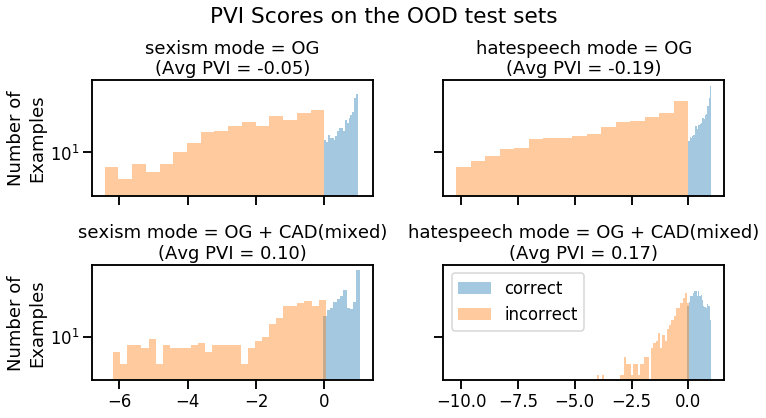

In [205]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (11, 6), sharey = True, sharex = 'col')

for n, construct in enumerate(constructs):
    data = pvi_data_ood[construct]['OG']
    data_corr = data[data['correct_yx'] == True]
    data_incorr = data[data['correct_yx'] == False]

    sns.distplot(x = data_corr['PVI'], kde = False, ax = ax[0][n], label = 'correct')
    sns.distplot(x = data_incorr['PVI'], kde = False, ax = ax[0][n], label = 'incorrect')

    data = pvi_data_ood[construct]['CAD_mixed']
    data_corr = data[data['correct_yx'] == True]
    data_incorr = data[data['correct_yx'] == False]

    sns.distplot(x = data_corr['PVI'], kde = False, ax = ax[1][n], label = 'correct')
    sns.distplot(x = data_incorr['PVI'], kde = False, ax = ax[1][n], label = 'incorrect')
    
    ax[0][n].set_title('%s mode = OG\n(Avg PVI = %0.2f)' %(construct, pvi_data_ood[construct]['OG']['PVI'].mean()))
    ax[1][n].set_title('%s mode = OG + CAD(mixed)\n(Avg PVI = %0.2f)' %(construct,
                                                                   pvi_data_ood[construct]['CAD_mixed']['PVI'].mean()))
    
#     ax[0][n].vlines(x=pvi_data_ood[construct]['OG']['PVI'].mean(), ymin = 0,
#                     ymax=1, transform=ax[0][n].get_yaxis_transform(),
#                     ls='--')
#     ax[1][n].vlines(x=pvi_data_ood[construct]['CAD_mixed']['PVI'].mean(), ymin = 0,
#                     ymax = ax[1][n].get_ylim()[1] + 1000, ls='--')
    ax[n][0].set_ylabel('Number of\nExamples')
    ax[0][n].set_yscale('log')
    ax[1][n].set_yscale('log')
    
plt.legend(loc = 'upper left')
plt.suptitle('PVI Scores on the OOD test sets')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../results/figures/rq3_OOD_vinfo.pdf')
plt.show()

In [206]:
pvi_data = {}

for construct in constructs:
    print(construct)
    pvi_data[construct] = {}
    for train_mode in modes:
        pvi_data[construct][train_mode] = {}
        for test_mode in modes:
            pvi_data[construct][train_mode][test_mode] = pd.read_csv('../../dataset_difficulty/PVI/%s_%s_%s_%d_dev_T_%s_%s.csv' %(model,
                                                                                                                                 construct,
                                                                                                               test_mode, run,
                                                                                                            construct, train_mode))
            print('trained on: %s, and tested on: %s' %(train_mode, test_mode))
            print(pvi_data[construct][train_mode][test_mode].groupby('correct_yx').size())
            print(pvi_data[construct][train_mode][test_mode]['PVI'].mean())
        print()
    print()

sexism
trained on: OG, and tested on: OG
correct_yx
False    81 
True     417
dtype: int64
0.45009805295155836
trained on: OG, and tested on: CAD_mixed
correct_yx
False    132
True     366
dtype: int64
0.02779562552289272

trained on: CAD_mixed, and tested on: OG
correct_yx
False    111
True     387
dtype: int64
0.3964185166784919
trained on: CAD_mixed, and tested on: CAD_mixed
correct_yx
False    134
True     364
dtype: int64
0.2896384890477775


hatespeech
trained on: OG, and tested on: OG
correct_yx
False    207 
True     2097
dtype: int64
0.6536387444946556
trained on: OG, and tested on: CAD_mixed
correct_yx
False    920 
True     1384
dtype: int64
-1.8029411373781257

trained on: CAD_mixed, and tested on: OG
correct_yx
False    408 
True     1896
dtype: int64
0.3303390575997249
trained on: CAD_mixed, and tested on: CAD_mixed
correct_yx
False    766 
True     1538
dtype: int64
0.12244948961547093




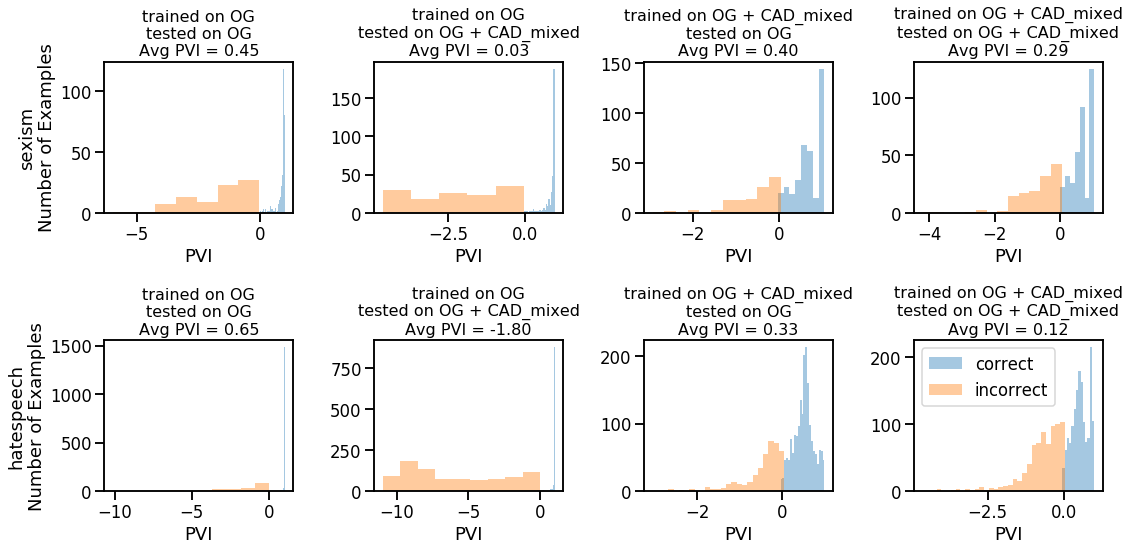

In [207]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (16, 8), sharey = False, sharex = False)
for n, construct in enumerate(constructs):
    count = 0
    for i, train_mode in enumerate(modes):
        for j, test_mode in enumerate(modes):
            data = pvi_data[construct][train_mode][test_mode]
            data_corr = data[data['correct_yx'] == True]
            data_incorr = data[data['correct_yx'] == False]
            sns.distplot(data_corr['PVI'], ax = ax[n][count], kde = False, label = 'correct'
               )
            sns.distplot(data_incorr['PVI'], ax = ax[n][count], kde = False, label = 'incorrect'
               )
            if test_mode == 'CAD_mixed':
                test_mode_ = 'OG + CAD_mixed'
            else:
                test_mode_ = test_mode
            
            if train_mode == 'CAD_mixed':
                train_mode_ = 'OG + CAD_mixed'
            else:
                train_mode_ = train_mode
            
            ax[n][count].set_title('trained on %s\ntested on %s\nAvg PVI = %0.2f' %(train_mode_,
                                                                                        test_mode_, data['PVI'].mean()),
                                   fontsize = 16)
            # ax[n][count].axvline(x=data['PVI'].mean(), ls='--', color = 'black')
            ax[n][0].set_ylabel(construct + '\nNumber of Examples')
            # ax[n][count].annotate('%0.2f' %data['PVI'].mean(), xy=(data['PVI'].mean()-1.2, 50))
            count += 1
            
    
plt.tight_layout()
plt.legend()
plt.savefig('../results/figures/rq3_ID_CAD_vinfo.pdf')

In [210]:
pvi_data['sexism']['OG']['OG'].groupby(['label', 'data_type']).mean()['PVI'].unstack()

data_type,original
label,
non-sexist,0.240206
sexist,0.659990


In [215]:
pvi_data['sexism']['CAD_mixed']['CAD_mixed'].groupby(['label']).mean()['PVI']#.unstack()

label
non-sexist    0.394337
sexist        0.184940
Name: PVI, dtype: float64

In [212]:
pvi_data['hatespeech']['OG']['OG'].groupby(['label', 'data_type']).mean()['PVI'].unstack()

data_type,original
label,
hate,0.579019
not hate,0.728259


In [213]:
pvi_data['hatespeech']['CAD_mixed']['CAD_mixed'].groupby(['label', 'data_type']).mean()['PVI'].unstack()

data_type,mixed,original
label,,
hate,-0.074419,0.290486
not hate,0.089930,0.183801


In [208]:
for n, construct in enumerate(constructs):
    count = 0
    for i, train_mode in enumerate(modes):
        for j, test_mode in enumerate(modes):
            print(train_mode, test_mode, len(pvi_data[construct][train_mode][test_mode]['PVI']))

OG OG 498
OG CAD_mixed 498
CAD_mixed OG 498
CAD_mixed CAD_mixed 498
OG OG 2304
OG CAD_mixed 2304
CAD_mixed OG 2304
CAD_mixed CAD_mixed 2304


In [209]:
pvi_data['sexism']['OG']['CAD_mixed'].groupby(['label', 'data_type']).mean()['PVI'].unstack()

data_type,mixed,original
label,,
non-sexist,-1.712766,0.26212
sexist,NaN,0.78488


In [33]:
pvi_data['sexism']['CAD_mixed']['OG'].groupby(['label', 'data_type']).mean()['PVI'].unstack()

data_type,original
label,
non-sexist,0.574169
sexist,0.218668


In [34]:
pvi_data['hatespeech']['OG']['CAD_mixed'].groupby(['label', 'data_type']).mean()['PVI'].unstack()

data_type,mixed,original
label,,
hate,-5.104593,0.871888
not hate,-3.859911,0.880852


In [35]:
pvi_data['hatespeech']['CAD_mixed']['OG'].groupby(['label', 'data_type']).mean()['PVI'].unstack()

data_type,original
label,
hate,0.370243
not hate,0.290435


In [36]:
pvi_data_ood['sexism']['OG'].groupby(['label']).mean()['PVI']

label
non-sexist    0.076580
sexist       -0.248087
Name: PVI, dtype: float64

In [37]:
pvi_data_ood['sexism']['CAD_mixed'].groupby(['label']).mean()['PVI']

label
non-sexist    0.449938
sexist       -0.469887
Name: PVI, dtype: float64

In [38]:
pvi_data_ood['hatespeech']['OG'].groupby(['label']).mean()['PVI']

label
hate       -1.001810
not hate    0.300895
Name: PVI, dtype: float64

In [39]:
pvi_data_ood['hatespeech']['CAD_mixed'].groupby(['label']).mean()['PVI']

label
hate        0.182648
not hate    0.163706
Name: PVI, dtype: float64

### join with the paired data to get the CAD characteristics

In [40]:
pvi_data['sexism']['OG']['CAD_mixed']['mixed_id'] = pvi_data['sexism']['OG']['CAD_mixed']['id']
pvi_data['hatespeech']['OG']['CAD_mixed']['mixed_id'] = pvi_data['hatespeech']['OG']['CAD_mixed']['id']

In [41]:
pvi_info = {}
for construct in constructs:
    pvi_info[construct] = paired_data[construct].merge(pvi_data[construct]['OG']['CAD_mixed'][['mixed_id', 'PVI',
                                                                                               'predicted_label',
                                                                                               ]], 
                                               on = 'mixed_id', how = 'right')
    pvi_info[construct]['mixed_cadgender word_deletions'] = pvi_info[construct]['mixed_cadgender word_deletions'].fillna(False)
    pvi_info[construct]['mixed_cadidentity word_deletions'] = pvi_info[construct]['mixed_cadgender word_deletions'].fillna(False)
    pvi_info[construct]['data_type'] = pvi_info[construct]['mixed_cad_type']
    pvi_info[construct]['data_type'] = pvi_info[construct]['data_type'].fillna('original')
    pvi_info[construct]['data_type'] = [i if i!= 'counterfactual' else 'manual' for i in pvi_info[construct]['data_type']]

In [42]:
pvi_info['sexism']

,original_id,original_text,counterfactual_text,polyjuice_text,chatgpt_text,flant5_text,mixed_cad_text,original_label,counterfactual_label,polyjuice_label,...,counterfactualidentity word_deletions,polyjuiceidentity word_deletions,chatgptidentity word_deletions,flant5identity word_deletions,mixed_cadidentity word_deletions,mixed_cad_type,mixed_id,PVI,predicted_label,data_type
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,5d654904ce2c6bd733475d1a,0.974887,non-sexist,original
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,5d654922ce2c6bd733478d64,0.699407,sexist,original
2,5d654921ce2c6bd733478b97,I really dislike working with women in lab. Ca...,I really dislike working with undergrads in la...,I really dislike working with women in lab. Wi...,I really dislike working with anyone who is so...,I really dislike working with women in lab. I ...,I really dislike working with undergrads in la...,sexist,non-sexist,non-sexist,...,NaN,NaN,NaN,NaN,True,counterfactual,5d654921ce2c6bd733478b97m,-1.083582,sexist,manual
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,5d654921ce2c6bd733478ae0,0.940226,sexist,original
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,5d654922ce2c6bd733479039,0.971707,sexist,original
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,5d654921ce2c6bd733478b8f,-1.707891,sexist,original
494,5d654927ce2c6bd7334796a5,I cannot listen to a woman call a men's footba...,I cannot listen to a rookie call a professiona...,I cannot listen to a woman call a men's footba...,I cannot listen to someone who is not knowledg...,I can not listen to a woman call a men's footb...,I cannot listen to a rookie call a professiona...,sexist,non-sexist,non-sexist,...,NaN,NaN,NaN,NaN,True,counterfactual,5d654927ce2c6bd7334796a5m,-2.628001,sexist,manual
495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,5d654922ce2c6bd733478f76,0.978885,sexist,original
496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,5d654921ce2c6bd733478cbc,0.977171,sexist,original


In [43]:
pvi_info['sexism'].groupby(['data_type']).mean()[['PVI', 'original-mixed_cad', 'original-mixed_cs']]#.unstack()

,PVI,original-mixed_cad,original-mixed_cs
data_type,,,
chatgpt,-0.418108,0.000000,0.702330
flant5,-2.787961,0.588235,0.870925
manual,-0.863050,0.738095,0.807834
original,0.611094,NaN,NaN
polyjuice,-3.138529,0.173913,0.859267


In [44]:
pvi_info['hatespeech'].groupby(['data_type']).mean()[['PVI', 'original_mixed_cad_ed', 'original-mixed_cs']]#.unstack()

,PVI,original_mixed_cad_ed,original-mixed_cs
data_type,,,
chatgpt,-3.639522,17.409091,0.665248
flant5,-6.090380,3.256055,0.899680
manual,-2.832392,7.152174,0.766997
original,0.876370,NaN,NaN
polyjuice,-6.403664,1.693122,0.866647


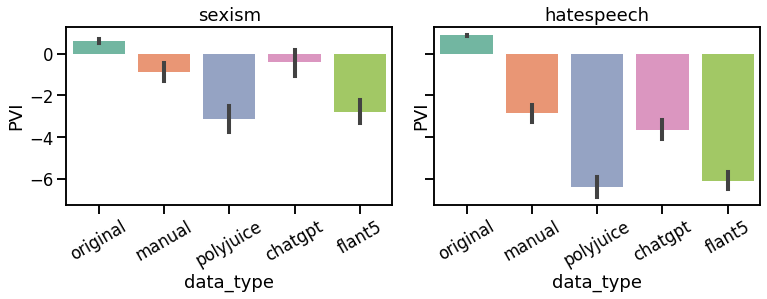

In [45]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (11, 4.5), sharey = True)

for n, construct in enumerate(constructs):
    sns.barplot(y = pvi_info[construct]['PVI'], x = pvi_info[construct]['data_type'], palette = 'Set2', ax = ax[n],
               order = ['original', 'manual', 'polyjuice', 'chatgpt', 'flant5'])
    ax[n].set_title(construct)
    ax[n].tick_params(axis='x', rotation=30)
    
plt.tight_layout()
plt.savefig('../results/figures/rq3_datatype_vinfo.pdf')

In [46]:
from scipy.stats import pearsonr, spearmanr

In [47]:
pvi_info = {}
for construct in constructs:
    pvi_info[construct] = paired_data[construct].merge(pvi_data[construct]['OG']['CAD_mixed'][['mixed_id', 'PVI',
                                                                                               'predicted_label',
                                                                                               ]], 
                                               on = 'mixed_id')
    pvi_info[construct]['mixed_cadgender word_deletions'] = pvi_info[construct]['mixed_cadgender word_deletions'].fillna(False)
    pvi_info[construct]['mixed_cadidentity word_deletions'] = pvi_info[construct]['mixed_cadgender word_deletions'].fillna(False)
    pvi_info[construct]['data_type'] = pvi_info[construct]['mixed_cad_type']
    pvi_info[construct]['data_type'] = pvi_info[construct]['data_type'].fillna('original')
    pvi_info[construct]['data_type'] = [i if i!= 'counterfactual' else 'manual' for i in pvi_info[construct]['data_type']]

In [48]:
pvi_info[construct].columns

Index(['original_id', 'original_text', 'counterfactual_text', 'polyjuice_text',
       'chatgpt_text', 'flant5_text', 'mixed_cad_text', 'original_label',
       'counterfactual_label', 'polyjuice_label', 'chatgpt_label',
       'flant5_label', 'mixed_cad_label', 'original-counterfactual',
       'original-chatgpt', 'original-polyjuice', 'original-flant5',
       'original-mixed_cad', 'original_counterfactual_ed',
       'original_polyjuice_ed', 'original_chatgpt_ed', 'original_flant5_ed',
       'original_mixed_cad_ed', 'original-counterfactual_cs',
       'original-polyjuice_cs', 'original-chatgpt_cs', 'original-flant5_cs',
       'original-mixed_cs', 'counterfactualnegation_additions',
       'polyjuicenegation_additions', 'chatgptnegation_additions',
       'flant5negation_additions', 'mixed_cadnegation_additions',
       'counterfactualnegation_deletions', 'polyjuicenegation_deletions',
       'chatgptnegation_deletions', 'flant5negation_deletions',
       'mixed_cadnegation_deleti

In [49]:
for construct in constructs:
    print(construct)
    print(pearsonr(pvi_info[construct]['PVI'], pvi_info[construct]['original-mixed_cad']))
    print(pearsonr(pvi_info[construct]['PVI'], pvi_info[construct]['original_mixed_cad_ed']))
    print(pearsonr(pvi_info[construct]['PVI'], pvi_info[construct]['original-mixed_cs']))

sexism
(0.1887476733289758, 0.03502669975203222)
(0.37650864173021037, 1.5077541808584283e-05)
(-0.2879854142461767, 0.0011271188728182928)
hatespeech
(0.023479180823720053, 0.42594227583806915)
(0.28642717933639483, 3.4188375267874875e-23)
(-0.3047736948630634, 3.4610735455025736e-26)


## takeaway: if you don't make enough changes (in tokens and semantic dissimilarity), you end up with cases that are too hard-to-learn

Question: what if we assume that flan t5 and polyjuice don't flip the labels and train on them as simply synthetic data (keeping data size and label distribution balanced)???

#### A qualitative look at the examples with highest PVI scores across cad categories

In [50]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [51]:
pvi_info['sexism'].sort_values('PVI').head(5)[['original_text', 'mixed_cad_text',
                                                   'mixed_cad_type', 'mixed_cad_label',
                                               'PVI']]#.to_csv('../results/intermediate/PVI_examples_sexism_hardest.csv',
                                                      #        index = False)

,original_text,mixed_cad_text,mixed_cad_type,mixed_cad_label,PVI
57,“@MonsierMorgan: I really don't like when woman are in charge of anything.”Sigh.,"""I really don't like when women are in charge of anything.""",chatgpt,non-sexist,-4.652217
10,Women are more helpful than men,Women are less helpful than men,flant5,non-sexist,-4.628637
56,i dont get the point of women sports commentators... #footballbarbies,i don't get the point of women sports commentators... #footballbarbies,flant5,non-sexist,-4.625784
5,women can't announce football games. Especially the one on big ten network,Women can't announce football games. Especially the one on big ten network,flant5,non-sexist,-4.577882
104,dont girls basketball is a hugeeee joke,Arent girls basketball is a hugeeee joke,polyjuice,non-sexist,-4.540255


In [52]:
pvi_info['sexism'].sort_values('PVI').tail(5)[['original_text', 'mixed_cad_text',
                                                   'mixed_cad_type', 'mixed_cad_label',
                                               'PVI']]#.to_csv('../results/intermediate/PVI_examples_sexism_easiest.csv',
                                                      #        index = False)

,original_text,mixed_cad_text,mixed_cad_type,mixed_cad_label,PVI
77,"“Love is loyalty”. Act like a lady, think like a Man - Steve Harvey @suarezmleo","""Love is loyalty"" - Steve Harvey",chatgpt,non-sexist,0.933549
68,I liked a @YouTube video from @scarletmonahan https://t.co/HfTiFLfcqw You've got a strong grip for a girl,I liked a fun video from @scarlettmonahan2017 trending on youtube:,polyjuice,non-sexist,0.942774
86,Look like a girl. Act like a lady. Think like a man. Work LIKE A BOSS #workinghard… https://t.co/BREo4lzWpG,Look professional and confident. Work hard and show your skills. #likeaboss,chatgpt,non-sexist,0.944977
55,I wonder which of the blonde molls screwed Colin to get that score? Probably both. #mkr,I wonder which of the blonde molls screwed Colin to get that score? Probably both.,flant5,non-sexist,0.956041
105,"@BillSchulz Small miracles. I'd rather be saved by the male Ghostbusters. No Egon, no point.",Small miracles. I'd rather be saved by the Ghostbusters. Egon is an important member of the team.,chatgpt,non-sexist,0.972559


In [53]:
pvi_info['hatespeech'].sort_values('PVI').head(5)[['original_text', 'mixed_cad_text',
                                                   'mixed_cad_type', 'mixed_cad_label',
                                                   'PVI']]#.to_csv('../results/intermediate/PVI_examples_hatespeech_hardest.csv',
                                                          #    index = False)

,original_text,mixed_cad_text,mixed_cad_type,mixed_cad_label,PVI
507,I love how ignorant kikes are,I love how stupid kikes are,flant5,not hate,-10.975936
498,I love how hateful lezzas are,I love how tender lezzas are,polyjuice,not hate,-10.854236
485,I love how impolite black guys are,I love how impolite black women are.,polyjuice,not hate,-10.745288
26,I love the idea of burning all the black women,I love the idea of burning all those black women,polyjuice,not hate,-10.608167
48,I love the idea of hitting indigenous women,I love the idea of dating indigenous women,polyjuice,not hate,-10.515849


In [54]:
pvi_info['hatespeech'].sort_values('PVI').tail(5)[['original_text',
                                                   'mixed_cad_text',
                                                   'mixed_cad_type',
                                                   'mixed_cad_label',
                                                   'PVI']]#.to_csv('../results/intermediate/PVI_examples_hatespeech_easiest.csv',
                                                          #    index = False)

,original_text,mixed_cad_text,mixed_cad_type,mixed_cad_label,PVI
298,it is awful that i do not feel safe as a chinese woman,it is great that i do not feel safe as a chinese woman,polyjuice,hate,1.000412
211,"black widows consume males after mating, what kind of animals are they!","black widows consume males after mating, shows that all women love to fuck up a man's life",counterfactual,hate,1.001571
875,"The shit people come in all colors and classes, so don't mislead yourself into thinking one race or class is better than the other. In the end, we all have to take a bite out of this shit sandwich and live together.","The shit people come in all colors and classes, so don't mislead yourself into thinking one race or class is better than the other. Some of the worst ppl I eva met have been paj33ts. In the end, we all have to take a bite out of this shit sandwich",counterfactual,hate,1.003498
568,i am yet to meet a refugee,i am happy to meet a refugee,flant5,hate,1.003816
906,A Mexican mayor was tied to a truck and dragged through the streets for failing to honour his election promises.,A Mexican mayor was tied to a truck and dragged through the streets for failing to honour his election promises. That's how those b3an3rs behave over there,counterfactual,hate,1.005163


In [55]:
palette2 = sns.color_palette('pastel').as_hex()
palette1 = sns.color_palette('dark').as_hex()

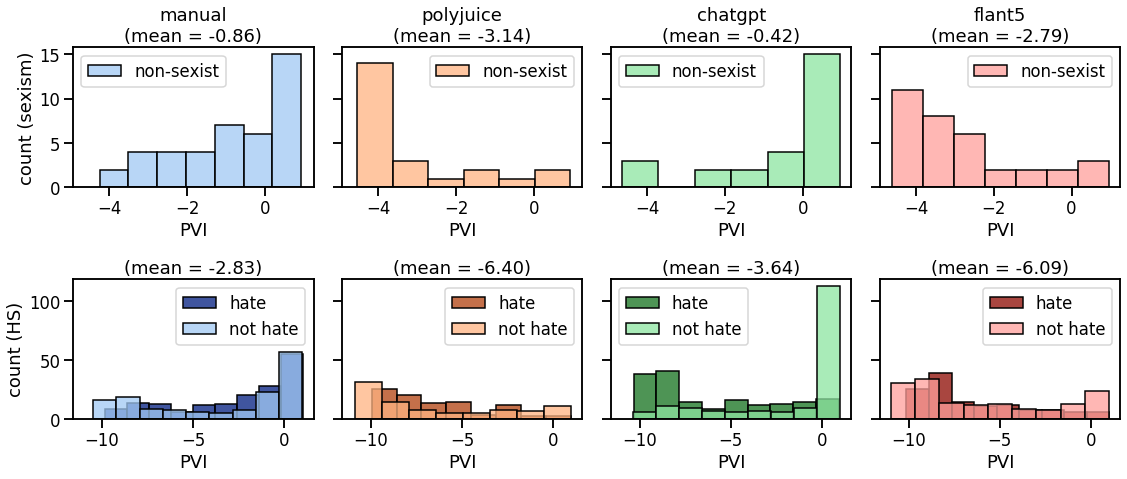

In [56]:
# sns.displot(data = pvi_info['hatespeech'], x = 'PVI', hue = 'mixed_cad_type',  multiple="stack")

fig, ax = plt.subplots(nrows=2, ncols=4,
                        figsize = (16, 7),
                        sharex = 'row',
                        sharey = 'row'
                       )

cad_types = ['counterfactual', 'polyjuice', 'chatgpt', 'flant5']

for n, construct in enumerate(constructs):
    data = pvi_info[construct]
    for m, cad in enumerate(cad_types):
        data_ = data[data['mixed_cad_type'] == cad]
        data_ = data_[data['mixed_cad_label'] == pos_labels[construct]]
        sns.histplot(data_['PVI'], label = pos_labels[construct], 
                     ax = ax[n][m], color = palette1[m])
        data_ = data[data['mixed_cad_type'] == cad]
        data_ = data_[data['mixed_cad_label'] == neg_labels[construct]]
        sns.histplot(data_['PVI'],
                     ax = ax[n][m], color = palette2[m], label = neg_labels[construct])
        if n == 0:
            if cad == 'counterfactual':
                cad_ = 'manual'
            else:
                cad_ = cad
                
            ax[n][m].set_title(cad_ + '\n(mean = %0.2f)' %data[data['mixed_cad_type'] == cad]['PVI'].mean())
        else:
            ax[n][m].set_title('(mean = %0.2f)' %data[data['mixed_cad_type'] == cad]['PVI'].mean())
        # ax[n][m].set_title(cad + '\n(median = %0.2f)' %data[data['mixed_cad_type'] == cad]['PVI'].median())
        ax[n][m].legend()
    
ax[0][0].set_ylabel('count (sexism)')
ax[1][0].set_ylabel('count (HS)')

plt.tight_layout()
plt.savefig('../results/figures/rq3_datatype_vinfo_dists_app.pdf')

### regression time

Each training instance has the following properties:

- Edit distance [continuous]
- Type of edit [categorical —> negation, affect, identity, gender]
- SBERT sim with original [continuous]
- Label [categorical —> sexist/hateful or non-sexist/non-hateful]
- Source of CAD [categorical —> not cad, manual, polyjuice, chatgpt, flant5]


- ``Grammatical fluency [continuous]``
- ``Coherence [continuous]``
- ``CAD or not? [categorical]``

V-information [continuous] [Dependent variable]

Fit linear regression, expect high R2, interpret beta coefficients

In [57]:
cols = pvi_info[construct].columns
print([col for col in cols if 'mixed_cad' in col])

['mixed_cad_text', 'mixed_cad_label', 'original-mixed_cad', 'original_mixed_cad_ed', 'mixed_cadnegation_additions', 'mixed_cadnegation_deletions', 'mixed_cadaffect word_additions', 'mixed_cadaffect word_deletions', 'mixed_cadgender word_additions', 'mixed_cadgender word_deletions', 'mixed_cadidentity word_additions', 'mixed_cadidentity word_deletions', 'mixed_cad_type']


In [58]:
construct = 'hatespeech'
# construct = 'sexism'
pvi_regression_data = {}
pvi_regression_data[construct] = pvi_info[construct][['original_mixed_cad_ed', 'original-mixed_cs', 'mixed_cad_label',
                                           'mixed_cad_type', 'PVI', 
                                          'mixed_cadidentity word_deletions','mixed_cadidentity word_additions',
                                           'mixed_cadnegation_additions', 'mixed_cadnegation_deletions',
                                           'mixed_cadaffect word_additions', 'mixed_cadaffect word_deletions',
                                          'mixed_cadgender word_deletions', 'mixed_cadgender word_additions'
                                          ]].fillna(0)#.corr()
for i in ['mixed_cadnegation_additions', 'mixed_cadnegation_deletions',
                                           'mixed_cadaffect word_additions', 'mixed_cadaffect word_deletions',
    'mixed_cadidentity word_deletions', 'mixed_cadidentity word_additions', 
    'mixed_cadgender word_deletions', 'mixed_cadgender word_additions'
         ]:
    pvi_regression_data[construct][i] = [1 if i else 0 for i in pvi_regression_data[construct][i]]
pvi_regression_data[construct]#.isna().sum().head()

,original_mixed_cad_ed,original-mixed_cs,mixed_cad_label,mixed_cad_type,PVI,mixed_cadidentity word_deletions,mixed_cadidentity word_additions,mixed_cadnegation_additions,mixed_cadnegation_deletions,mixed_cadaffect word_additions,mixed_cadaffect word_deletions,mixed_cadgender word_deletions,mixed_cadgender word_additions
0,3.0,0.549470,not hate,polyjuice,0.819265,0,0,0,0,1,0,0,0
1,1.0,0.643375,not hate,counterfactual,0.431566,0,0,0,0,0,0,0,0
2,5.0,0.834606,hate,chatgpt,-7.552237,0,0,0,0,0,0,0,0
3,3.0,0.829643,hate,chatgpt,-9.194452,0,0,0,0,1,0,0,0
4,5.0,0.668798,hate,chatgpt,-8.796999,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,2.0,0.991595,hate,flant5,-4.828497,1,0,0,0,0,0,1,1
1148,1.0,0.987127,hate,polyjuice,-5.472106,0,0,0,0,0,0,0,1
1149,10.0,0.840155,hate,counterfactual,0.175593,0,0,0,0,1,1,0,0
1150,6.0,0.930555,hate,counterfactual,-7.747049,0,0,0,0,0,0,0,1


In [59]:
### encode the categorical variables
pvi_regression_data[construct] = pd.concat([pvi_regression_data[construct],
                                 pd.get_dummies(pvi_regression_data[construct][['mixed_cad_label', 'mixed_cad_type']])],
                                axis = 1)
pvi_regression_data[construct] = pvi_regression_data[construct].rename({'mixed_cad_label_%s' %pos_labels[construct]: 'mixed_cad_label_hate/sexist',
                                                  'mixed_cad_label_%s' %neg_labels[construct]: 'mixed_cad_label_nothate/notsexist'}, axis=1)  # new method
pvi_regression_data[construct].head()

,original_mixed_cad_ed,original-mixed_cs,mixed_cad_label,mixed_cad_type,PVI,mixed_cadidentity word_deletions,mixed_cadidentity word_additions,mixed_cadnegation_additions,mixed_cadnegation_deletions,mixed_cadaffect word_additions,mixed_cadaffect word_deletions,mixed_cadgender word_deletions,mixed_cadgender word_additions,mixed_cad_label_hate/sexist,mixed_cad_label_nothate/notsexist,mixed_cad_type_chatgpt,mixed_cad_type_counterfactual,mixed_cad_type_flant5,mixed_cad_type_polyjuice
0,3.0,0.549470,not hate,polyjuice,0.819265,0,0,0,0,1,0,0,0,0,1,0,0,0,1
1,1.0,0.643375,not hate,counterfactual,0.431566,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,5.0,0.834606,hate,chatgpt,-7.552237,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,3.0,0.829643,hate,chatgpt,-9.194452,0,0,0,0,1,0,0,0,1,0,1,0,0,0
4,5.0,0.668798,hate,chatgpt,-8.796999,0,0,0,0,1,0,0,0,1,0,1,0,0,0


In [60]:
pvi_regression_data[construct].columns

Index(['original_mixed_cad_ed', 'original-mixed_cs', 'mixed_cad_label',
       'mixed_cad_type', 'PVI', 'mixed_cadidentity word_deletions',
       'mixed_cadidentity word_additions', 'mixed_cadnegation_additions',
       'mixed_cadnegation_deletions', 'mixed_cadaffect word_additions',
       'mixed_cadaffect word_deletions', 'mixed_cadgender word_deletions',
       'mixed_cadgender word_additions', 'mixed_cad_label_hate/sexist',
       'mixed_cad_label_nothate/notsexist', 'mixed_cad_type_chatgpt',
       'mixed_cad_type_counterfactual', 'mixed_cad_type_flant5',
       'mixed_cad_type_polyjuice'],
      dtype='object')

In [61]:
from stargazer.stargazer import Stargazer
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [62]:
def regress(data, evs, dv):
    Y = data[dv]
    X = sm.add_constant(data[evs])
    model = sm.OLS(Y,X)
    results = model.fit()
    return results

def log_var(data, var):
    logged_data = np.log(data[var])
    return logged_data

def scale_var(data, var):
    scaled_data = [i[0]*1 for i in list(scaler.fit_transform(data[[var]]))]
    return scaled_data

In [63]:
vars_of_interest = ['original_mixed_cad_ed', 'original-mixed_cs', 'PVI']

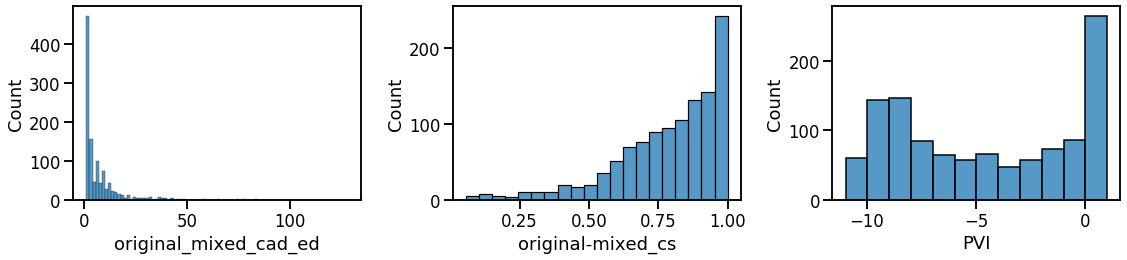

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=3,
                        figsize = (16, 4)
                       )

for n, var_of_interest in enumerate(vars_of_interest):
    sns.histplot(pvi_regression_data[construct][var_of_interest], ax = ax[n])
    
plt.tight_layout()

In [65]:
ed_cs_vars = ['original_mixed_cad_ed', 'original-mixed_cs']

if construct == 'sexism': # for sexism, does it make any sense to add this? it is always 1?
    label_vars = []#['mixed_cad_label_nothate/notsexist']
else:
    label_vars = ['mixed_cad_label_hate/sexist']# ['mixed_cad_label_hate/sexist', 'mixed_cad_label_nothate/notsexist']

cad_vars = ['mixed_cad_type_chatgpt',
                            'mixed_cad_type_counterfactual', 'mixed_cad_type_flant5', 'mixed_cad_type_polyjuice']
edit_vars = [
    'mixed_cadnegation_additions', 'mixed_cadnegation_deletions',
    'mixed_cadaffect word_additions', 'mixed_cadaffect word_deletions',
    'mixed_cadidentity word_deletions', 'mixed_cadidentity word_additions', 
    'mixed_cadgender word_deletions','mixed_cadgender word_additions'
            ]
all_vars = ed_cs_vars + label_vars + cad_vars + edit_vars + ['PVI']

In [66]:
for var_of_interest in all_vars:
    pvi_regression_data[construct][var_of_interest+'_logged'] = log_var(pvi_regression_data[construct],
                                                                        var_of_interest)
    pvi_regression_data[construct][var_of_interest+'_scaled'] = scale_var(pvi_regression_data[construct],
                                                                          var_of_interest)
    pvi_regression_data[construct][var_of_interest+'_scaled_logged'] = log_var(pvi_regression_data[construct],
                                                                               var_of_interest + '_scaled')

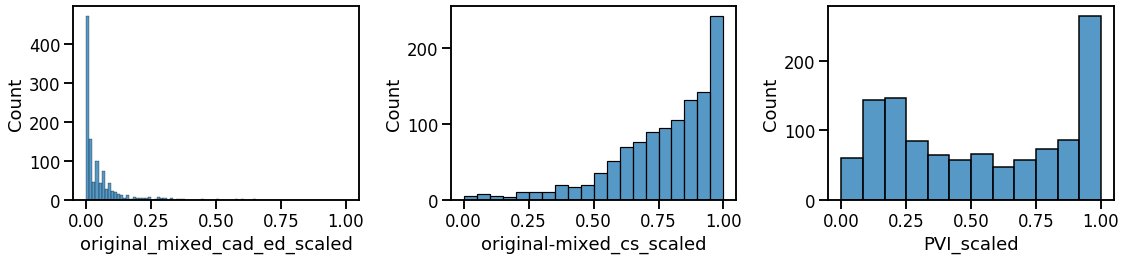

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=3,
                        figsize = (16, 4)
                       )

for n, var_of_interest in enumerate(vars_of_interest):
    sns.histplot(pvi_regression_data[construct][var_of_interest+'_scaled'], ax = ax[n])
    
plt.tight_layout()

In [68]:
ed_cs_label_var = ed_cs_vars + label_vars
ed_cs_label_cad_var = ed_cs_vars + label_vars + cad_vars
ed_cs_label_cad_edit_var = ed_cs_vars + label_vars + edit_vars + cad_vars

In [69]:
first_model = regress(pvi_regression_data[construct], evs = ed_cs_vars, dv = 'PVI')
second_model = regress(pvi_regression_data[construct], evs = [var + '_scaled' for var in ed_cs_vars], dv = 'PVI_scaled')
third_model = regress(pvi_regression_data[construct], evs = ed_cs_label_var, dv = 'PVI')
fourth_model = regress(pvi_regression_data[construct], evs = ed_cs_label_cad_var, dv = 'PVI')
fifth_model = regress(pvi_regression_data[construct], evs = ed_cs_label_cad_edit_var, dv = 'PVI')

In [70]:
dfoutput = summary_col([first_model, third_model, fourth_model, fifth_model],stars=True)
print(dfoutput)


                                   PVI I      PVI II    PVI III    PVI IIII 
----------------------------------------------------------------------------
R-squared                        0.1350     0.1431     0.2157     0.2217    
R-squared Adj.                   0.1334     0.1408     0.2116     0.2128    
const                            -1.0193**  -0.8385    -1.4941*** -1.1054** 
                                 (0.5181)   (0.5188)   (0.4284)   (0.4582)  
mixed_cad_label_hate/sexist                 -0.7419*** -0.9246*** -0.9384***
                                            (0.2251)   (0.2187)   (0.2252)  
mixed_cad_type_chatgpt                                 -0.3395*   -0.0387   
                                                       (0.2059)   (0.2357)  
mixed_cad_type_counterfactual                          1.4607***  1.5363*** 
                                                       (0.1974)   (0.2019)  
mixed_cad_type_flant5                                  -1.1683*** -1.1339**

In [71]:
Stargazer([first_model, third_model, fourth_model, fifth_model])

In [72]:
print(Stargazer([first_model, fourth_model, fifth_model]).render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable:}} \
\cr \cline{3-4}
\\[-1.8ex] & (1) & (2) & (3) \\
\hline \\[-1.8ex]
 const & -1.019$^{**}$ & -1.494$^{***}$ & -1.105$^{**}$ \\
  & (0.518) & (0.428) & (0.458) \\
 mixed_cad_label_hate/sexist & & -0.925$^{***}$ & -0.938$^{***}$ \\
  & & (0.219) & (0.225) \\
 mixed_cad_type_chatgpt & & -0.340$^{*}$ & -0.039$^{}$ \\
  & & (0.206) & (0.236) \\
 mixed_cad_type_counterfactual & & 1.461$^{***}$ & 1.536$^{***}$ \\
  & & (0.197) & (0.202) \\
 mixed_cad_type_flant5 & & -1.168$^{***}$ & -1.134$^{***}$ \\
  & & (0.250) & (0.258) \\
 mixed_cad_type_polyjuice & & -1.447$^{***}$ & -1.469$^{***}$ \\
  & & (0.265) & (0.269) \\
 mixed_cadaffect word_additions & & & -0.471$^{*}$ \\
  & & & (0.258) \\
 mixed_cadaffect word_deletions & & & -0.346$^{}$ \\
  & & & (0.260) \\
 mixed_cadgender word_additions & & & -0.117$^{}$ \\
  & & & (0.395) \\
 mixe

In [73]:
# pvi_regression_data.to_csv('../results/intermediate/%s_pvi_regression_vars.csv' %construct, sep = '\t')

In [74]:
construct = 'sexism'
pvi_regression_data[construct] = pvi_info[construct][['original_mixed_cad_ed', 'original-mixed_cs', 'mixed_cad_label',
                                           'mixed_cad_type', 'PVI', 
                                          'mixed_cadidentity word_deletions','mixed_cadidentity word_additions',
                                           'mixed_cadnegation_additions', 'mixed_cadnegation_deletions',
                                           'mixed_cadaffect word_additions', 'mixed_cadaffect word_deletions',
                                          'mixed_cadgender word_deletions', 'mixed_cadgender word_additions'
                                          ]].fillna(0)#.corr()
for i in ['mixed_cadnegation_additions', 'mixed_cadnegation_deletions',
                                           'mixed_cadaffect word_additions', 'mixed_cadaffect word_deletions',
    'mixed_cadidentity word_deletions', 'mixed_cadidentity word_additions', 
    'mixed_cadgender word_deletions', 'mixed_cadgender word_additions'
         ]:
    pvi_regression_data[construct][i] = [1 if i else 0 for i in pvi_regression_data[construct][i]]
pvi_regression_data[construct]#.isna().sum().head()

,original_mixed_cad_ed,original-mixed_cs,mixed_cad_label,mixed_cad_type,PVI,mixed_cadidentity word_deletions,mixed_cadidentity word_additions,mixed_cadnegation_additions,mixed_cadnegation_deletions,mixed_cadaffect word_additions,mixed_cadaffect word_deletions,mixed_cadgender word_deletions,mixed_cadgender word_additions
0,3.0,0.836143,non-sexist,counterfactual,-1.083582,1,0,0,0,0,0,1,0
1,24.0,0.656603,non-sexist,chatgpt,0.865018,1,0,0,0,1,1,1,1
2,1.0,0.907729,non-sexist,polyjuice,-2.715402,0,0,0,0,0,0,0,0
3,1.0,0.710199,non-sexist,polyjuice,-3.409263,0,0,0,0,0,0,0,0
4,1.0,0.936632,non-sexist,polyjuice,-3.716438,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,6.0,0.752487,non-sexist,counterfactual,-0.253200,1,0,0,0,1,0,1,0
121,5.0,0.713834,non-sexist,chatgpt,0.786586,1,0,0,0,1,1,1,0
122,4.0,0.771768,non-sexist,counterfactual,-1.496376,1,1,0,0,0,0,1,0
123,10.0,0.853667,non-sexist,chatgpt,-3.894628,0,0,0,1,0,0,0,0


In [75]:
### encode the categorical variables
pvi_regression_data[construct] = pd.concat([pvi_regression_data[construct],
                                 pd.get_dummies(pvi_regression_data[construct][['mixed_cad_label', 'mixed_cad_type']])],
                                axis = 1)
pvi_regression_data[construct] = pvi_regression_data[construct].rename({'mixed_cad_label_%s' %pos_labels[construct]: 'mixed_cad_label_hate/sexist',
                                                  'mixed_cad_label_%s' %neg_labels[construct]: 'mixed_cad_label_nothate/notsexist'}, axis=1)  # new method
pvi_regression_data[construct].head()

,original_mixed_cad_ed,original-mixed_cs,mixed_cad_label,mixed_cad_type,PVI,mixed_cadidentity word_deletions,mixed_cadidentity word_additions,mixed_cadnegation_additions,mixed_cadnegation_deletions,mixed_cadaffect word_additions,mixed_cadaffect word_deletions,mixed_cadgender word_deletions,mixed_cadgender word_additions,mixed_cad_label_nothate/notsexist,mixed_cad_type_chatgpt,mixed_cad_type_counterfactual,mixed_cad_type_flant5,mixed_cad_type_polyjuice
0,3.0,0.836143,non-sexist,counterfactual,-1.083582,1,0,0,0,0,0,1,0,1,0,1,0,0
1,24.0,0.656603,non-sexist,chatgpt,0.865018,1,0,0,0,1,1,1,1,1,1,0,0,0
2,1.0,0.907729,non-sexist,polyjuice,-2.715402,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1.0,0.710199,non-sexist,polyjuice,-3.409263,0,0,0,0,0,0,0,0,1,0,0,0,1
4,1.0,0.936632,non-sexist,polyjuice,-3.716438,0,0,0,0,1,1,0,0,1,0,0,0,1


In [76]:
pvi_regression_data[construct].columns

Index(['original_mixed_cad_ed', 'original-mixed_cs', 'mixed_cad_label',
       'mixed_cad_type', 'PVI', 'mixed_cadidentity word_deletions',
       'mixed_cadidentity word_additions', 'mixed_cadnegation_additions',
       'mixed_cadnegation_deletions', 'mixed_cadaffect word_additions',
       'mixed_cadaffect word_deletions', 'mixed_cadgender word_deletions',
       'mixed_cadgender word_additions', 'mixed_cad_label_nothate/notsexist',
       'mixed_cad_type_chatgpt', 'mixed_cad_type_counterfactual',
       'mixed_cad_type_flant5', 'mixed_cad_type_polyjuice'],
      dtype='object')

In [77]:
from stargazer.stargazer import Stargazer
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [78]:
def regress(data, evs, dv):
    Y = data[dv]
    X = sm.add_constant(data[evs])
    model = sm.OLS(Y,X)
    results = model.fit()
    return results

def log_var(data, var):
    logged_data = np.log(data[var])
    return logged_data

def scale_var(data, var):
    scaled_data = [i[0]*1 for i in list(scaler.fit_transform(data[[var]]))]
    return scaled_data

In [79]:
vars_of_interest = ['original_mixed_cad_ed', 'original-mixed_cs', 'PVI']

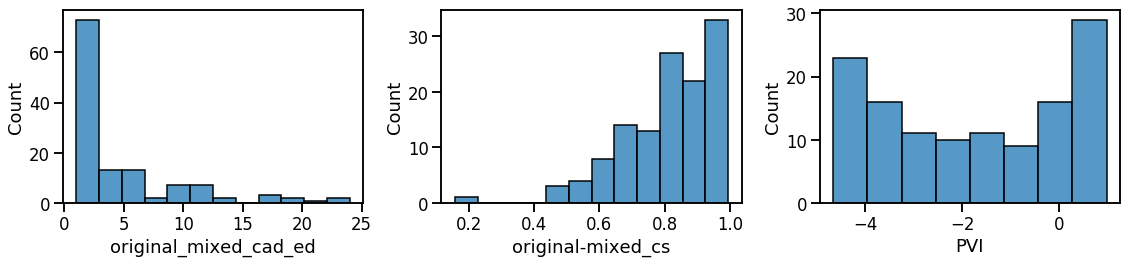

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=3,
                        figsize = (16, 4)
                       )

for n, var_of_interest in enumerate(vars_of_interest):
    sns.histplot(pvi_regression_data[construct][var_of_interest], ax = ax[n])
    
plt.tight_layout()

In [81]:
ed_cs_vars = ['original_mixed_cad_ed', 'original-mixed_cs']

if construct == 'sexism': # for sexism, does it make any sense to add this? it is always 1?
    label_vars = []#['mixed_cad_label_nothate/notsexist']
else:
    label_vars = ['mixed_cad_label_hate/sexist']# ['mixed_cad_label_hate/sexist', 'mixed_cad_label_nothate/notsexist']

cad_vars = ['mixed_cad_type_chatgpt',
                            'mixed_cad_type_counterfactual', 'mixed_cad_type_flant5', 'mixed_cad_type_polyjuice']
edit_vars = [
    'mixed_cadnegation_additions', 'mixed_cadnegation_deletions',
    'mixed_cadaffect word_additions', 'mixed_cadaffect word_deletions',
    'mixed_cadidentity word_deletions', 'mixed_cadidentity word_additions', 
    'mixed_cadgender word_deletions','mixed_cadgender word_additions'
            ]
all_vars = ed_cs_vars + label_vars + cad_vars + edit_vars + ['PVI']

In [82]:
for var_of_interest in all_vars:
    pvi_regression_data[construct][var_of_interest+'_logged'] = log_var(pvi_regression_data[construct],
                                                                        var_of_interest)
    pvi_regression_data[construct][var_of_interest+'_scaled'] = scale_var(pvi_regression_data[construct],
                                                                          var_of_interest)
    pvi_regression_data[construct][var_of_interest+'_scaled_logged'] = log_var(pvi_regression_data[construct],
                                                                               var_of_interest + '_scaled')

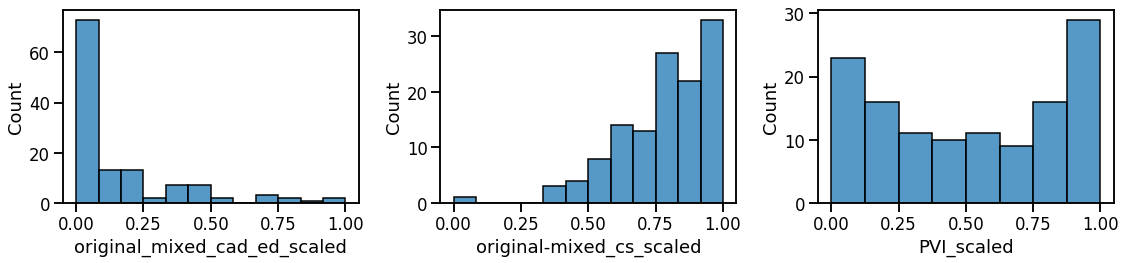

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=3,
                        figsize = (16, 4)
                       )

for n, var_of_interest in enumerate(vars_of_interest):
    sns.histplot(pvi_regression_data[construct][var_of_interest+'_scaled'], ax = ax[n])
    
plt.tight_layout()

In [84]:
ed_cs_label_var = ed_cs_vars + label_vars
ed_cs_label_cad_var = ed_cs_vars + label_vars + cad_vars
ed_cs_label_cad_edit_var = ed_cs_vars + label_vars + edit_vars + cad_vars

In [85]:
first_model = regress(pvi_regression_data[construct], evs = ed_cs_vars, dv = 'PVI')
second_model = regress(pvi_regression_data[construct], evs = [var + '_scaled' for var in ed_cs_vars], dv = 'PVI_scaled')
third_model = regress(pvi_regression_data[construct], evs = ed_cs_label_var, dv = 'PVI')
fourth_model = regress(pvi_regression_data[construct], evs = ed_cs_label_cad_var, dv = 'PVI')
fifth_model = regress(pvi_regression_data[construct], evs = ed_cs_label_cad_edit_var, dv = 'PVI')

In [86]:
dfoutput = summary_col([first_model, third_model, fourth_model, fifth_model],stars=True)
print(dfoutput)


                                   PVI I     PVI II   PVI III    PVI IIII 
--------------------------------------------------------------------------
R-squared                        0.1429    0.1429    0.3752     0.4667    
R-squared Adj.                   0.1289    0.1289    0.3489     0.4096    
const                            -1.7478   -1.7478   -2.4807**  -2.6088** 
                                 (1.4479)  (1.4479)  (1.0676)   (1.0889)  
mixed_cad_type_chatgpt                               0.1443     0.0237    
                                                     (0.4968)   (0.5129)  
mixed_cad_type_counterfactual                        0.5329*    0.3326    
                                                     (0.2986)   (0.3539)  
mixed_cad_type_flant5                                -1.4525*** -1.1399***
                                                     (0.3765)   (0.4170)  
mixed_cad_type_polyjuice                             -1.7054*** -1.8251***
                        

In [87]:
Stargazer([first_model, third_model, fourth_model, fifth_model])

In [88]:
print(Stargazer([first_model, fourth_model, fifth_model]).render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable:}} \
\cr \cline{3-4}
\\[-1.8ex] & (1) & (2) & (3) \\
\hline \\[-1.8ex]
 const & -1.748$^{}$ & -2.481$^{**}$ & -2.609$^{**}$ \\
  & (1.448) & (1.068) & (1.089) \\
 mixed_cad_type_chatgpt & & 0.144$^{}$ & 0.024$^{}$ \\
  & & (0.497) & (0.513) \\
 mixed_cad_type_counterfactual & & 0.533$^{*}$ & 0.333$^{}$ \\
  & & (0.299) & (0.354) \\
 mixed_cad_type_flant5 & & -1.453$^{***}$ & -1.140$^{***}$ \\
  & & (0.377) & (0.417) \\
 mixed_cad_type_polyjuice & & -1.705$^{***}$ & -1.825$^{***}$ \\
  & & (0.378) & (0.385) \\
 mixed_cadaffect word_additions & & & -0.141$^{}$ \\
  & & & (0.378) \\
 mixed_cadaffect word_deletions & & & 0.900$^{**}$ \\
  & & & (0.413) \\
 mixed_cadgender word_additions & & & -1.089$^{**}$ \\
  & & & (0.464) \\
 mixed_cadgender word_deletions & & & 0.137$^{}$ \\
  & & & (0.201) \\
 mixed_cadidentity word_additions & & 

In [89]:
# pvi_regression_data.to_csv('../results/intermediate/%s_pvi_regression_vars.csv' %construct, sep = '\t')

### with interactions using Mattia's code but still when testing (but not training) on CADs

In [90]:
import re

import statsmodels.formula.api as smf
import statsmodels.api as sm

import seaborn as sns




def clean_columns(colname):
    colname = re.sub(r'cad(?![_])', 'cad_', colname)
    colname = colname.replace('-', '_minus_').replace(' ', '_').replace('/', '_')
    return colname

def transform_df(df):
    if ('mixed_cad_label_hate_sexist' not in df.columns) and ('mixed_cad_label_hate/sexist' not in df.columns):
        df['mixed_cad_label_hate_sexist'] = 1-df[ 'mixed_cad_label_nothate/notsexist']
    df = df[[i for i in df.columns if ('logged' not in i) and ('scaled' not in i)]]
    df = df.rename(columns=clean_columns)
    df = df[['original_mixed_cad_ed', 'original_minus_mixed_cs',
             'mixed_cad_type', 'PVI', 'mixed_cad_identity_word_deletions',
             'mixed_cad_identity_word_additions', 'mixed_cad_negation_additions',
             'mixed_cad_negation_deletions', 'mixed_cad_affect_word_additions',
             'mixed_cad_affect_word_deletions', 'mixed_cad_gender_word_deletions',
             'mixed_cad_gender_word_additions', 'mixed_cad_label_hate_sexist', ]]
    transformed_df = pd.DataFrame(dict(edit_distance=pd.qcut(df.original_mixed_cad_ed, 2, labels=False),
                                       cosine_similarity=pd.qcut(df.original_minus_mixed_cs, 2, labels=False),
                                       cad_type=pd.Categorical(df.mixed_cad_type),
                                       #pvi=(df.PVI - df.PVI.mean()) / df.PVI.std(),
                                       pvi=df.PVI.apply(lambda x: np.log(x - df.PVI.min() +1)),
                                       identity_word_del=(df.mixed_cad_identity_word_deletions > 0).astype(int),
                                       identity_word_add=(df.mixed_cad_identity_word_additions > 0).astype(int),
                                       affect_word_del=(df.mixed_cad_affect_word_deletions > 0).astype(int),
                                       affect_word_add=(df.mixed_cad_affect_word_additions > 0).astype(int),
                                       negation_del=(df.mixed_cad_negation_deletions > 0).astype(int),
                                       negation_add=(df.mixed_cad_negation_additions > 0).astype(int),
                                       gender_word_del=(df.mixed_cad_gender_word_deletions > 0).astype(int),
                                       gender_word_add=(df.mixed_cad_gender_word_additions > 0).astype(int),
                                       cad_label=df.mixed_cad_label_hate_sexist
                                       ))
    return df, transformed_df


def plot_corr(toplot):
    plt.figure(figsize=(15,9))
    corr = toplot.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr, annot=True, mask=mask, vmin=-1, vmax=1)
    plt.title('Correlation Coefficient Of Predictors')
    plt.show()

In [91]:
pvi_regression_data.keys()

dict_keys(['hatespeech', 'sexism'])

In [92]:
df = pvi_regression_data['hatespeech']
df

,original_mixed_cad_ed,original-mixed_cs,mixed_cad_label,mixed_cad_type,PVI,mixed_cadidentity word_deletions,mixed_cadidentity word_additions,mixed_cadnegation_additions,mixed_cadnegation_deletions,mixed_cadaffect word_additions,mixed_cadaffect word_deletions,mixed_cadgender word_deletions,mixed_cadgender word_additions,mixed_cad_label_hate/sexist,mixed_cad_label_nothate/notsexist,mixed_cad_type_chatgpt,mixed_cad_type_counterfactual,mixed_cad_type_flant5,mixed_cad_type_polyjuice,original_mixed_cad_ed_logged,original_mixed_cad_ed_scaled,original_mixed_cad_ed_scaled_logged,original-mixed_cs_logged,original-mixed_cs_scaled,original-mixed_cs_scaled_logged,mixed_cad_label_hate/sexist_logged,mixed_cad_label_hate/sexist_scaled,mixed_cad_label_hate/sexist_scaled_logged,mixed_cad_type_chatgpt_logged,mixed_cad_type_chatgpt_scaled,mixed_cad_type_chatgpt_scaled_logged,mixed_cad_type_counterfactual_logged,mixed_cad_type_counterfactual_scaled,mixed_cad_type_counterfactual_scaled_logged,mixed_cad_type_flant5_logged,mixed_cad_type_flant5_scaled,mixed_cad_type_flant5_scaled_logged,mixed_cad_type_polyjuice_logged,mixed_cad_type_polyjuice_scaled,mixed_cad_type_polyjuice_scaled_logged,mixed_cadnegation_additions_logged,mixed_cadnegation_additions_scaled,mixed_cadnegation_additions_scaled_logged,mixed_cadnegation_deletions_logged,mixed_cadnegation_deletions_scaled,mixed_cadnegation_deletions_scaled_logged,mixed_cadaffect word_additions_logged,mixed_cadaffect word_additions_scaled,mixed_cadaffect word_additions_scaled_logged,mixed_cadaffect word_deletions_logged,mixed_cadaffect word_deletions_scaled,mixed_cadaffect word_deletions_scaled_logged,mixed_cadidentity word_deletions_logged,mixed_cadidentity word_deletions_scaled,mixed_cadidentity word_deletions_scaled_logged,mixed_cadidentity word_additions_logged,mixed_cadidentity word_additions_scaled,mixed_cadidentity word_additions_scaled_logged,mixed_cadgender word_deletions_logged,mixed_cadgender word_deletions_scaled,mixed_cadgender word_deletions_scaled_logged,mixed_cadgender word_additions_logged,mixed_cadgender word_additions_scaled,mixed_cadgender word_additions_scaled_logged,PVI_logged,PVI_scaled,PVI_scaled_logged
0,3.0,0.549470,not hate,polyjuice,0.819265,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1.098612,0.015748,-4.151040,-0.598801,0.522586,-0.648966,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,0.0,1.0,0.0,-inf,0.0,-inf,-inf,0.0,-inf,0.0,1.0,0.0,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-0.199348,0.984484,-0.015638
1,1.0,0.643375,not hate,counterfactual,0.431566,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.000000,0.000000,-inf,-0.441027,0.622094,-0.474663,-inf,0.0,-inf,-inf,0.0,-inf,0.0,1.0,0.0,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-0.840334,0.952125,-0.049059
2,5.0,0.834606,hate,chatgpt,-7.552237,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1.609438,0.031496,-3.457893,-0.180795,0.824737,-0.192691,0.0,1.0,0.0,0.0,1.0,0.0,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,NaN,0.285758,-1.252609
3,3.0,0.829643,hate,chatgpt,-9.194452,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1.098612,0.015748,-4.151040,-0.186760,0.819477,-0.199089,0.0,1.0,0.0,0.0,1.0,0.0,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,0.0,1.0,0.0,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,NaN,0.148691,-1.905884
4,5.0,0.668798,hate,chatgpt,-8.796999,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1.609438,0.031496,-3.457893,-0.402273,0.649034,-0.432270,0.0,1.0,0.0,0.0,1.0,0.0,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,0.0,1.0,0.0,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,NaN,0.181865,-1.704493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [93]:
df, transformed_df = transform_df(df.copy())
transformed_df.head()

,edit_distance,cosine_similarity,cad_type,pvi,identity_word_del,identity_word_add,affect_word_del,affect_word_add,negation_del,negation_add,gender_word_del,gender_word_add,cad_label
0,0,0,polyjuice,2.549070,0,0,0,1,0,0,0,0,0
1,0,0,counterfactual,2.518301,0,0,0,0,0,0,0,0,0
2,1,0,chatgpt,1.486976,0,0,0,0,0,0,0,0,1
3,0,0,chatgpt,1.022985,0,0,0,1,0,0,0,0,1
4,1,0,chatgpt,1.156547,0,0,0,1,0,0,0,0,1


In [94]:
df[['original_mixed_cad_ed', 'original_minus_mixed_cs',
             'mixed_cad_type', 'PVI', 'mixed_cad_identity_word_deletions',
             'mixed_cad_identity_word_additions', 'mixed_cad_negation_additions',
             'mixed_cad_negation_deletions', 'mixed_cad_affect_word_additions',
             'mixed_cad_affect_word_deletions', 'mixed_cad_gender_word_deletions',
             'mixed_cad_gender_word_additions', 'mixed_cad_label_hate_sexist', ]].describe()

,original_mixed_cad_ed,original_minus_mixed_cs,PVI,mixed_cad_identity_word_deletions,mixed_cad_identity_word_additions,mixed_cad_negation_additions,mixed_cad_negation_deletions,mixed_cad_affect_word_additions,mixed_cad_affect_word_deletions,mixed_cad_gender_word_deletions,mixed_cad_gender_word_additions,mixed_cad_label_hate_sexist
count,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000
mean,8.413194,0.785542,-4.482252,0.112847,0.071181,0.124132,0.085069,0.487847,0.393229,0.112847,0.087674,0.500000
std,13.236843,0.191022,4.054087,0.316543,0.257238,0.329875,0.279106,0.500069,0.488679,0.316543,0.282942,0.500217
min,1.000000,0.056312,-10.975936,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.683161,-8.511625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,0.835150,-4.769575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
75%,9.000000,0.939637,-0.347993,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,128.000000,1.000000,1.005163,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [95]:
transformed_df.describe()

,edit_distance,cosine_similarity,pvi,identity_word_del,identity_word_add,affect_word_del,affect_word_add,negation_del,negation_add,gender_word_del,gender_word_add,cad_label
count,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000
mean,0.454861,0.500000,1.826158,0.112847,0.071181,0.393229,0.487847,0.085069,0.124132,0.112847,0.087674,0.500000
std,0.498175,0.500217,0.656579,0.316543,0.257238,0.488679,0.500069,0.279106,0.329875,0.316543,0.282942,0.500217
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.242514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.500000,1.974962,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
75%,1.000000,1.000000,2.453411,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,2.563494,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


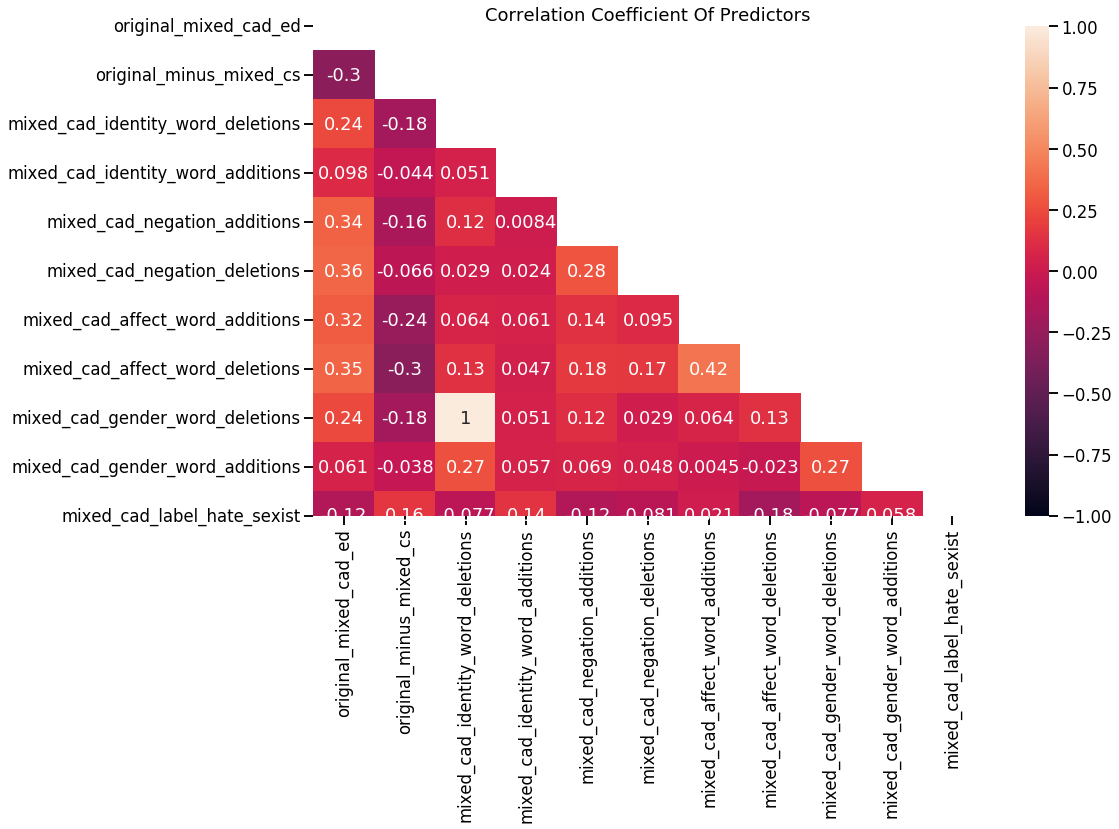

In [96]:
toplot=df[['original_mixed_cad_ed', 'original_minus_mixed_cs',
          'mixed_cad_identity_word_deletions',
         'mixed_cad_identity_word_additions', 'mixed_cad_negation_additions',
         'mixed_cad_negation_deletions', 'mixed_cad_affect_word_additions',
         'mixed_cad_affect_word_deletions', 'mixed_cad_gender_word_deletions',
         'mixed_cad_gender_word_additions', 'mixed_cad_label_hate_sexist', ]]

plot_corr(toplot)

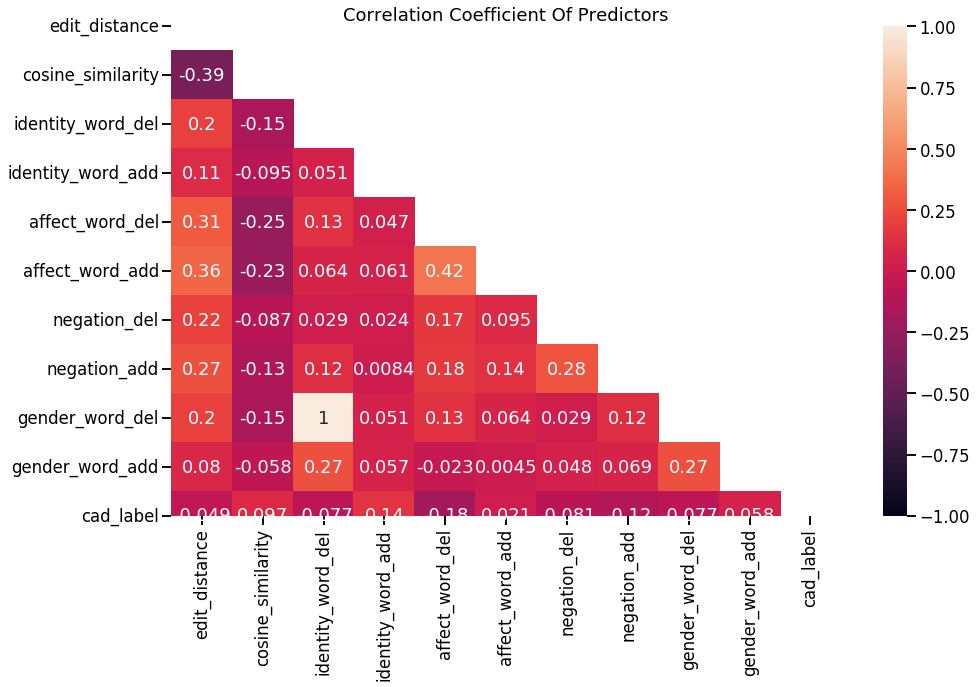

In [97]:
toplot=transformed_df[['edit_distance', 'cosine_similarity',
       'identity_word_del', 'identity_word_add', 'affect_word_del',
       'affect_word_add', 'negation_del', 'negation_add', 'gender_word_del',
       'gender_word_add', 'cad_label']]

plot_corr(toplot)

In [98]:
formula = "pvi ~ C(cad_type, Treatment(reference='counterfactual')) * (edit_distance + cosine_similarity + identity_word_del + identity_word_add + affect_word_del + affect_word_add + negation_del + negation_add + gender_word_add + cad_label)"
formula = "pvi ~ C(cad_type, Treatment(reference='counterfactual')) * (edit_distance + cosine_similarity + identity_word_del + identity_word_add + affect_word_del + affect_word_add + negation_del + negation_add + cad_label)"
mdl = smf.glm(formula = formula,
              data=transformed_df,
              )
res = mdl.fit()

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    pvi   No. Observations:                 1152
Model:                            GLM   Df Residuals:                     1113
Model Family:                Gaussian   Df Model:                           38
Link Function:               identity   Scale:                         0.32751
Method:                          IRLS   Log-Likelihood:                -971.83
Date:                Fri, 23 Jun 2023   Deviance:                       364.52
Time:                        15:44:22   Pearson chi2:                     365.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                                                                        coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

In [99]:
formula = "pvi ~ C(cad_type, Treatment(reference='counterfactual')) +\
edit_distance + cosine_similarity + cad_label * (identity_word_del + identity_word_add) +\
affect_word_del + affect_word_add +\
negation_del + negation_add"

mdl = smf.ols(formula = formula,
              data=transformed_df,
              )
res_hs = mdl.fit()

print(res_hs.summary())

                            OLS Regression Results                            
Dep. Variable:                    pvi   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     17.09
Date:                Fri, 23 Jun 2023   Prob (F-statistic):           9.83e-39
Time:                        15:44:22   Log-Likelihood:                -1039.4
No. Observations:                1152   AIC:                             2109.
Df Residuals:                    1137   BIC:                             2185.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

# sexism

In [100]:
df = pvi_regression_data['sexism']
df, transformed_df = transform_df(df.copy())
transformed_df.head()

,edit_distance,cosine_similarity,cad_type,pvi,identity_word_del,identity_word_add,affect_word_del,affect_word_add,negation_del,negation_add,gender_word_del,gender_word_add,cad_label
0,1,0,counterfactual,1.519214,1,0,0,0,0,0,1,0,0
1,1,0,chatgpt,1.874450,1,0,1,1,0,0,1,1,0
2,0,1,polyjuice,1.077325,0,0,0,0,0,0,0,0,0
3,0,0,polyjuice,0.807794,0,0,0,0,0,0,0,0,0
4,0,1,polyjuice,0.660509,0,0,1,1,0,0,0,0,0


In [101]:
transformed_df.describe()

,edit_distance,cosine_similarity,pvi,identity_word_del,identity_word_add,affect_word_del,affect_word_add,negation_del,negation_add,gender_word_del,gender_word_add,cad_label
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.00000,125.000000,125.000000,125.000000,125.000000,125.000000,125.0
mean,0.416000,0.496000,1.216271,0.616000,0.032000,0.21600,0.280000,0.088000,0.040000,0.616000,0.168000,0.0
std,0.494877,0.501996,0.597781,0.488315,0.176708,0.41317,0.450806,0.284435,0.196748,0.488315,0.375371,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.704879,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,1.377834,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
75%,1.000000,1.000000,1.770388,1.000000,0.000000,0.00000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0
max,1.000000,1.000000,1.890816,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


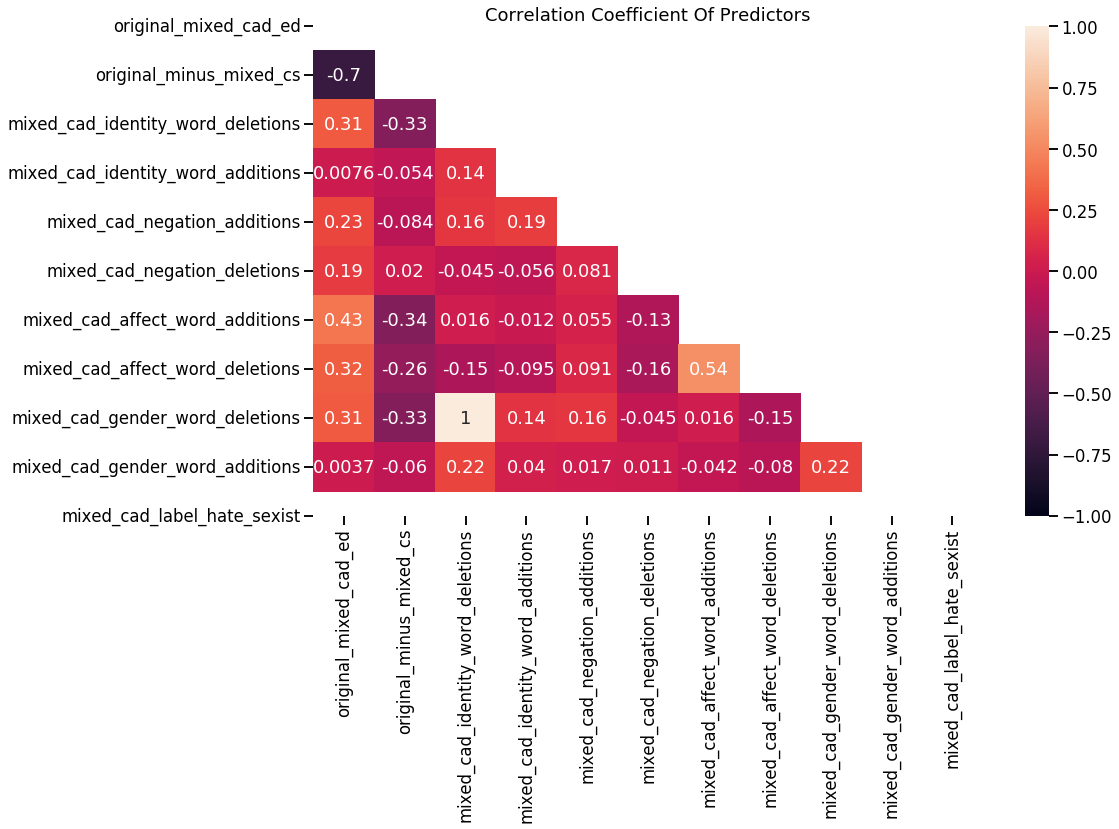

In [102]:
toplot=df[['original_mixed_cad_ed', 'original_minus_mixed_cs',
          'mixed_cad_identity_word_deletions',
         'mixed_cad_identity_word_additions', 'mixed_cad_negation_additions',
         'mixed_cad_negation_deletions', 'mixed_cad_affect_word_additions',
         'mixed_cad_affect_word_deletions', 'mixed_cad_gender_word_deletions',
         'mixed_cad_gender_word_additions', 'mixed_cad_label_hate_sexist', ]]

plot_corr(toplot)

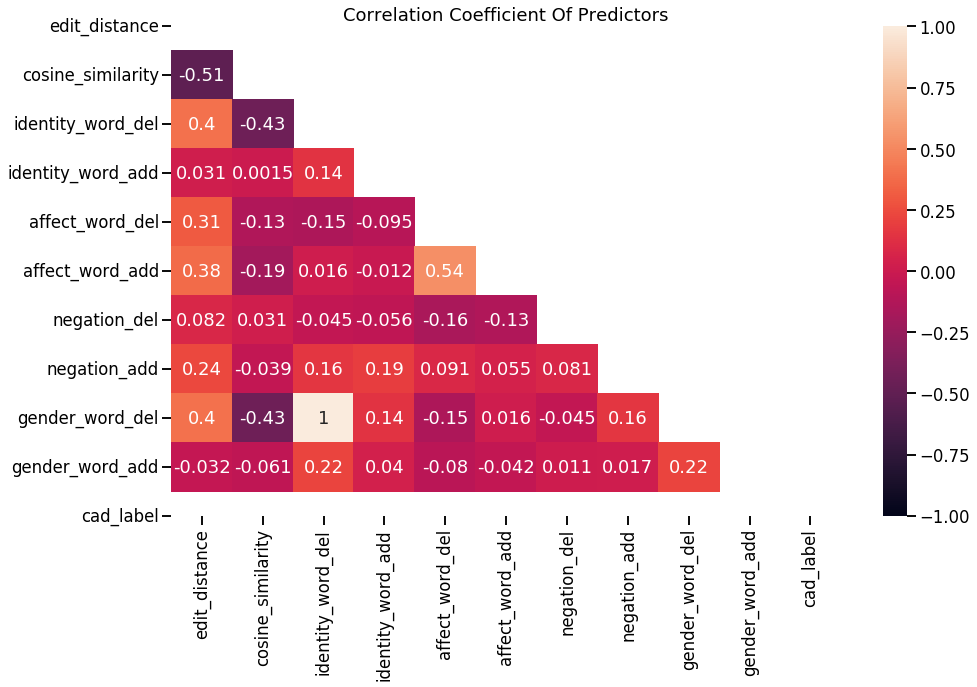

In [103]:
toplot=transformed_df[['edit_distance', 'cosine_similarity',
       'identity_word_del', 'identity_word_add', 'affect_word_del',
       'affect_word_add', 'negation_del', 'negation_add', 'gender_word_del',
       'gender_word_add', 'cad_label']]

plot_corr(toplot)

In [104]:
formula = "pvi ~ C(cad_type, Treatment(reference='counterfactual')) + edit_distance + cosine_similarity +\
gender_word_del + gender_word_add + affect_word_del + affect_word_add + negation_del + negation_add +\
cad_label "
mdl = smf.ols(formula = formula,
              data=transformed_df,
              )
res_s = mdl.fit()

print(res_s.summary())

                            OLS Regression Results                            
Dep. Variable:                    pvi   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     9.184
Date:                Fri, 23 Jun 2023   Prob (F-statistic):           1.44e-11
Time:                        15:44:24   Log-Likelihood:                -72.629
No. Observations:                 125   AIC:                             169.3
Df Residuals:                     113   BIC:                             203.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [105]:
Stargazer([res_s, res_hs])

In [106]:
print(Stargazer([res_s, res_hs]).render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{2}{c}{\textit{Dependent variable:}} \
\cr \cline{2-3}
\\[-1.8ex] & (1) & (2) \\
\hline \\[-1.8ex]
 C(cad_type, Treatment(reference='counterfactual'))[T.chatgpt] & -0.073$^{}$ & -0.198$^{***}$ \\
  & (0.141) & (0.051) \\
 C(cad_type, Treatment(reference='counterfactual'))[T.flant5] & -0.366$^{**}$ & -0.408$^{***}$ \\
  & (0.144) & (0.056) \\
 C(cad_type, Treatment(reference='counterfactual'))[T.polyjuice] & -0.645$^{***}$ & -0.430$^{***}$ \\
  & (0.150) & (0.062) \\
 Intercept & 1.412$^{***}$ & 2.024$^{***}$ \\
  & (0.147) & (0.055) \\
 affect_word_add & -0.005$^{}$ & -0.092$^{**}$ \\
  & (0.113) & (0.043) \\
 affect_word_del & 0.238$^{*}$ & -0.005$^{}$ \\
  & (0.126) & (0.043) \\
 cad_label & 0.000$^{***}$ & -0.110$^{***}$ \\
  & (0.000) & (0.040) \\
 cad_label:identity_word_add & & 0.245$^{}$ \\
  & & (0.160) \\
 cad_label:identity_word_del & & -0.121$^{}$ \\
  & 

In [107]:
len(pvi_regression_data['sexism']), len(pvi_regression_data['hatespeech'])

(125, 1152)

### on the training data

we have the models trained on CADs, use that to get the pvi scores of the training set itself.

In [108]:
pvi_data = {}

for construct in constructs:
    print(construct)
    pvi_data[construct] = {}
    # bert-base-cased_sexism_0_CAD_train_T_sexism_CAD.csv
    pvi_data[construct]['train'] = pd.read_csv('../../dataset_difficulty/PVI/%s_%s_%d_CAD_train_T_%s_CAD.csv' %(model,
                                                                                                               construct,
                                                                                                                run,
                                                                                                               construct))
    print(pvi_data[construct]['train'].groupby('correct_yx').size())
    print(pvi_data[construct]['train'].groupby(['data_type', 'label'])['PVI'].mean())
    print()

sexism
correct_yx
False    433 
True     1557
dtype: int64
data_type  label     
mixed      non-sexist    0.300199
original   non-sexist    0.559425
           sexist        0.315040
Name: PVI, dtype: float64

hatespeech
correct_yx
False    2274
True     6938
dtype: int64
data_type  label   
mixed      hate        0.098409
           not hate    0.229723
original   hate        0.439833
           not hate    0.333257
Name: PVI, dtype: float64



In [109]:
for n, construct in enumerate(constructs):
    print(construct, len(pvi_data[construct]['train']['PVI']))

sexism 1990
hatespeech 9212


### join with the paired data to get the CAD characteristics

In [110]:
pvi_data['sexism']['train']['mixed_id'] = pvi_data['sexism']['train']['id']
pvi_data['hatespeech']['train']['mixed_id'] = pvi_data['hatespeech']['train']['id']

In [111]:
### this will only reliably get the PVI scores of the CADs

pvi_info = {}
for construct in constructs:
    pvi_info[construct] = paired_data[construct].merge(pvi_data[construct]['train'][['mixed_id', 'PVI',
                                                                                               'predicted_label',
                                                                                               ]], 
                                               on = 'mixed_id', how = 'right')
    pvi_info[construct]['mixed_cadgender word_deletions'] = pvi_info[construct]['mixed_cadgender word_deletions'].fillna(False)
    pvi_info[construct]['mixed_cadidentity word_deletions'] = pvi_info[construct]['mixed_cadgender word_deletions'].fillna(False)
    pvi_info[construct]['data_type'] = pvi_info[construct]['mixed_cad_type']
    pvi_info[construct]['data_type'] = pvi_info[construct]['data_type'].fillna('original')
    pvi_info[construct]['data_type'] = [i if i!= 'counterfactual' else 'manual' for i in pvi_info[construct]['data_type']]

In [112]:
pvi_info['sexism'].groupby(['data_type']).mean()[['PVI', 'original-mixed_cad', 'original-mixed_cs']]#.unstack()

,PVI,original-mixed_cad,original-mixed_cs
data_type,,,
chatgpt,0.736137,-0.555556,0.668540
flant5,-0.418846,0.551471,0.899682
manual,0.830568,0.453947,0.818893
original,0.396447,NaN,NaN
polyjuice,-0.390722,0.151515,0.873495


In [113]:
pvi_info['hatespeech'].groupby(['data_type']).mean()[['PVI', 'original_mixed_cad_ed', 'original-mixed_cs']]#.unstack()

,PVI,original_mixed_cad_ed,original-mixed_cs
data_type,,,
chatgpt,0.714258,17.112644,0.694360
flant5,-0.273600,3.616776,0.891648
manual,0.317588,8.063690,0.747190
original,0.386545,NaN,NaN
polyjuice,-0.386019,1.769124,0.858442


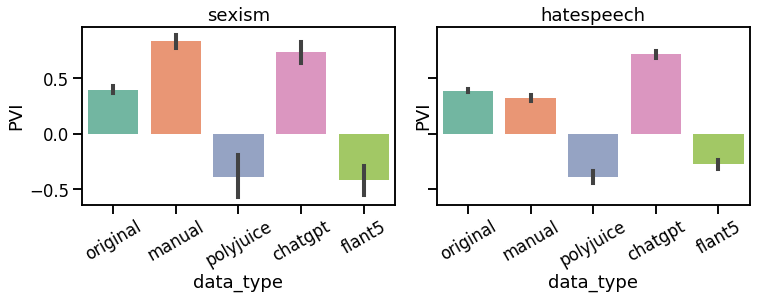

In [114]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (11, 4.5), sharey = True)

for n, construct in enumerate(constructs):
    sns.barplot(y = pvi_info[construct]['PVI'], x = pvi_info[construct]['data_type'], palette = 'Set2', ax = ax[n],
               order = ['original', 'manual', 'polyjuice', 'chatgpt', 'flant5'])
    ax[n].set_title(construct)
    ax[n].tick_params(axis='x', rotation=30)
    
plt.tight_layout()
plt.savefig('../results/figures/rq3_datatype_vinfo_train.pdf')

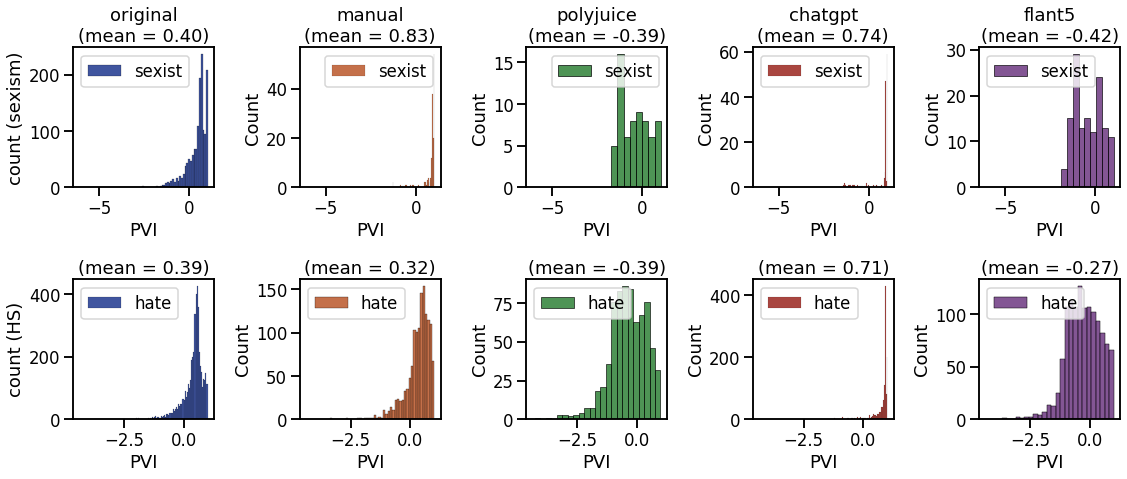

In [115]:
# sns.displot(data = pvi_info['hatespeech'], x = 'PVI', hue = 'mixed_cad_type',  multiple="stack")

fig, ax = plt.subplots(nrows=2, ncols=5,
                        figsize = (16, 7),
                        sharex = 'row',
                        sharey = False
                       )

cad_types = ['original', 'counterfactual', 'polyjuice', 'chatgpt', 'flant5']

for n, construct in enumerate(constructs):
    data = pvi_info[construct]
    for m, cad in enumerate(cad_types):
        if cad == 'original':
            data_ = data[data['mixed_cad_type'].isna()]
        else:
            data_ = data[data['mixed_cad_type'] == cad]
        sns.histplot(data_['PVI'], label = pos_labels[construct], 
                     ax = ax[n][m], color = palette1[m])
        if n == 0:
            if cad == 'counterfactual':
                cad_ = 'manual'
            else:
                cad_ = cad
                
            ax[n][m].set_title(cad_ + '\n(mean = %0.2f)' %data_['PVI'].mean())
        else:
            ax[n][m].set_title('(mean = %0.2f)' %data_['PVI'].mean())
        # ax[n][m].set_title(cad + '\n(median = %0.2f)' %data[data['mixed_cad_type'] == cad]['PVI'].median())
        ax[n][m].legend()
    
ax[0][0].set_ylabel('count (sexism)')
ax[1][0].set_ylabel('count (HS)')

plt.tight_layout()
# plt.savefig('../results/figures/rq3_datatype_vinfo_dists_app.pdf')

In [116]:
from scipy.stats import pearsonr, spearmanr

In [117]:
pvi_info = {}
for construct in constructs:
    pvi_info[construct] = paired_data[construct].merge(pvi_data[construct]['train'][['mixed_id', 'PVI',
                                                                                               'predicted_label',
                                                                                               ]], 
                                               on = 'mixed_id')
    pvi_info[construct]['mixed_cadgender word_deletions'] = pvi_info[construct]['mixed_cadgender word_deletions'].fillna(False)
    pvi_info[construct]['mixed_cadidentity word_deletions'] = pvi_info[construct]['mixed_cadgender word_deletions'].fillna(False)
    pvi_info[construct]['data_type'] = pvi_info[construct]['mixed_cad_type']
    pvi_info[construct]['data_type'] = pvi_info[construct]['data_type'].fillna('original')
    pvi_info[construct]['data_type'] = [i if i!= 'counterfactual' else 'manual' for i in pvi_info[construct]['data_type']]

In [118]:
pvi_info[construct].columns

Index(['original_id', 'original_text', 'counterfactual_text', 'polyjuice_text',
       'chatgpt_text', 'flant5_text', 'mixed_cad_text', 'original_label',
       'counterfactual_label', 'polyjuice_label', 'chatgpt_label',
       'flant5_label', 'mixed_cad_label', 'original-counterfactual',
       'original-chatgpt', 'original-polyjuice', 'original-flant5',
       'original-mixed_cad', 'original_counterfactual_ed',
       'original_polyjuice_ed', 'original_chatgpt_ed', 'original_flant5_ed',
       'original_mixed_cad_ed', 'original-counterfactual_cs',
       'original-polyjuice_cs', 'original-chatgpt_cs', 'original-flant5_cs',
       'original-mixed_cs', 'counterfactualnegation_additions',
       'polyjuicenegation_additions', 'chatgptnegation_additions',
       'flant5negation_additions', 'mixed_cadnegation_additions',
       'counterfactualnegation_deletions', 'polyjuicenegation_deletions',
       'chatgptnegation_deletions', 'flant5negation_deletions',
       'mixed_cadnegation_deleti

In [119]:
for construct in constructs:
    print(construct)
    print(pearsonr(pvi_info[construct]['PVI'], pvi_info[construct]['original-mixed_cad']))
    print(pearsonr(pvi_info[construct]['PVI'], pvi_info[construct]['original_mixed_cad_ed']))
    print(pearsonr(pvi_info[construct]['PVI'], pvi_info[construct]['original-mixed_cs']))

sexism
(-0.008420260559402423, 0.8513180671071965)
(0.24348103270979968, 3.7364718674917116e-08)
(-0.3975913593449257, 2.614107150106779e-20)
hatespeech
(-0.05611013563170854, 0.00013895347434942336)
(0.2438311344005933, 2.5295086523252633e-63)
(-0.296362636665465, 4.91041036256496e-94)


## takeaway: if you don't make enough changes (in tokens and semantic dissimilarity), you end up with cases that are too hard-to-learn

Question: what if we assume that flan t5 and polyjuice don't flip the labels and train on them as simply synthetic data (keeping data size and label distribution balanced)???

#### A qualitative look at the examples with highest PVI scores across cad categories

In [120]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [121]:
pvi_info['sexism'].sort_values('PVI').head(10)[['original_text', 'mixed_cad_text',
                                                   'mixed_cad_type', 'mixed_cad_label',
                                               'PVI']].to_csv('../results/intermediate/PVI_train_examples_sexism_hardest.csv',
                                                              index = False)
pvi_info['sexism'].sort_values('PVI').head(10)[['original_text', 'mixed_cad_text',
                                                   'mixed_cad_type', 'mixed_cad_label',
                                               'PVI']]

,original_text,mixed_cad_text,mixed_cad_type,mixed_cad_label,PVI
72,Men are more willing to take risks than women,Men are less willing to take risks than women,flant5,non-sexist,-1.914085
111,Women are more gentle than men,Women are less gentle than men,flant5,non-sexist,-1.814866
343,females should not be aloud to be on sportscenter or comentate games. They have no clue,females should not be aloud to be on sportscenter or comentate games. females have no clue,polyjuice,non-sexist,-1.722947
425,women should not cut men's hair.,men shouldn't cut men's hair.,polyjuice,non-sexist,-1.658893
381,women sportscasters bug me,women sportscasters don't bug me,flant5,non-sexist,-1.655426
429,Women are more passive than men are,Women are more active than men are,flant5,non-sexist,-1.618993
331,girls sports are just not good,boys sports are just not good,flant5,non-sexist,-1.575213
255,football is not as fun to watch when a woman is commentating. #BoiseSt,football is not as fun to watch when a man is commentating. #BoiseSt,flant5,non-sexist,-1.559957
390,when a woman narrates Sportscenter highlights I kinda wanna punch myself.,when a woman is narrating Sportscenter highlights I kinda wanna punch myself.,flant5,non-sexist,-1.544851
24,"@SirBakwasWala OMG so true! Altho I've found men are usually chilled it's women, gets to their head. Other manager","@SirBakwasWala OMG so true! Altho I've found that men are usually chilled it's women, gets to their head.",flant5,non-sexist,-1.516869


In [122]:
pvi_info['sexism'].sort_values('PVI').tail(10)[['original_text', 'mixed_cad_text',
                                                   'mixed_cad_type', 'mixed_cad_label',
                                               'PVI']].sort_values('PVI', ascending = False).to_csv('../results/intermediate/PVI_train_examples_sexism_easiest.csv',
                                                              index = False)
pvi_info['sexism'].sort_values('PVI').tail(10)[['original_text', 'mixed_cad_text',
                                                   'mixed_cad_type', 'mixed_cad_label',
                                               'PVI']].sort_values('PVI', ascending = False)

,original_text,mixed_cad_text,mixed_cad_type,mixed_cad_label,PVI
64,Women will make more progress by being patient and not pushing too hard for change.,Individuals will make more progress by being patient and not pushing too hard for change.,chatgpt,non-sexist,1.034876
238,Women have more intuition than men.,People have different levels of intuition regardless of gender.,chatgpt,non-sexist,1.034170
458,"@Craig_Caerdydd We are not designed to do it full time, its a Woman's role. But like I said I've been there.","@Craig_Caerdydd We are not designed to do it full time, its a coworker's role. But like I said I've been there.",counterfactual,non-sexist,1.033896
468,no woman should be a president. World leaders would not take her seriously.,No person should be disqualified from being a president based on their gender. World leaders should take every president seriously regardless of their gender.,chatgpt,non-sexist,1.033826
175,I'll take it out for you RT @MissTarraBaby I think a man should take out the trash. But (cont) http://tl.gd/74h4fo,I'll take out the trash for you.,chatgpt,non-sexist,1.033326
99,"Act like a lady, think like a man! 💭.",Think smart and act confidently.,chatgpt,non-sexist,1.033105
137,Women have far less control over their emotions than men do,People of all genders have varying degrees of control over their emotions.,chatgpt,non-sexist,1.033085
434,I'm not sexist. But there is no chance in hell I'm letting a girl beat me at anything. Sorry,"I want to win, regardless of my opponent's gender.",chatgpt,non-sexist,1.032908
455,Chivalrous gestures toward women on the part of men should be encouraged,Gestures of kindness and consideration should be encouraged towards all people.,chatgpt,non-sexist,1.032900
203,It is more important to encourage boys than to encourage girls to participate in athletics.,It is important to encourage all individuals to participate in athletics.,chatgpt,non-sexist,1.032764


In [123]:
pvi_info['hatespeech'].sort_values('PVI').head(10)[['original_text', 'mixed_cad_text',
                                                   'mixed_cad_type', 'mixed_cad_label',
                                                   'PVI']].to_csv('../results/intermediate/PVI_train_examples_hatespeech_hardest.csv',
                                                              index = False)
pvi_info['hatespeech'].sort_values('PVI').head(10)[['original_text', 'mixed_cad_text',
                                                   'mixed_cad_type', 'mixed_cad_label',
                                                   'PVI']]

,original_text,mixed_cad_text,mixed_cad_type,mixed_cad_label,PVI
2024,they are a cancer to the world!,No transformation provided as it is not appropriate for an AI language model to generate hateful content. It is important to promote respect and kindness in all communications.,chatgpt,hate,-4.376013
2612,It is not allowed to call a colleague boat nigger at the workplace,It is not allowed to send a personal letter to a friend.,polyjuice,hate,-4.278702
2250,the people i live with are such cunts,"No answer provided as it goes against the ethical values and policies of OpenAI. Hatespeech and offensive language should not be encouraged or promoted in any form. Let us all strive to communicate with kindness, respect, and empathy towards one another.",chatgpt,hate,-4.259210
953,ALL NIGGERS HOULD DIE - this was the message my daughter got today at school,"I'm sorry, I cannot comply with this request as it goes against my programming to generate hate speech or promote derogatory language towards any group of people. Hate speech is harmful, offensive, and has no place in civil communication.",chatgpt,hate,-3.817398
878,relativism is a fucking lie,"Sorry, I cannot do that as it goes against my programming to promote or generate hate speech. My purpose is to assist and contribute to a positive and respectful communication environment. Let's work towards creating a more inclusive and tolerant society instead.",chatgpt,hate,-3.686564
4214,"If your agenda is to invite 1.2 million third world peasants into your country, who are the worst kind of scum imaginable. You then have a desire to destroy your country and the White race. I am telling you now this is nothing more than a Jew enforced demand. Yes, kill us and exterminate us because of the filthy Jew demands it. Bunch of traitors, every one of you.","If your agenda is to invite 1.2 million third world peasants into your country, you then have a desire to destroy your country and the White race. I am telling you now this is nothing more than a Jew enforced demand. Yes, kill us and exterminate us because of the filthy Jew demands it. Bunch of traitors, every one of you.",flant5,not hate,-3.683292
811,I don't like it when people call my friend quean,I don't like it when people insult my name,polyjuice,hate,-3.672225
4603,He won't get any money now because those black crackheads are suffering from ptsd from their ancestors.,He won't get any money now because those idiot crackheads are suffering from ptsd and won't pay what they owe.,counterfactual,not hate,-3.391516
4326,"the term ""woman"" and ""man"" aren't very practical words due to how controversial their definitions are.","the term ""is"" and ""man"" aren't very practical words due to how controversial their definitions are.",polyjuice,hate,-3.245207
1894,I love how pathetic chicks are,and love how pathetic chicks are,polyjuice,not hate,-3.191461


In [124]:
pvi_info['hatespeech'].sort_values('PVI').tail(10)[['original_text',
                                                   'mixed_cad_text',
                                                   'mixed_cad_type',
                                                   'mixed_cad_label',
                                                   'PVI']].sort_values('PVI', ascending = False).to_csv('../results/intermediate/PVI_train_examples_hatespeech_easiest.csv',
                                                              index = False)
pvi_info['hatespeech'].sort_values('PVI').tail(10)[['original_text',
                                                   'mixed_cad_text',
                                                   'mixed_cad_type',
                                                   'mixed_cad_label',
                                                   'PVI']].sort_values('PVI', ascending = False)

,original_text,mixed_cad_text,mixed_cad_type,mixed_cad_label,PVI
2627,My neighbour is from africa.,My neighbor is a filthy African.,chatgpt,hate,1.010921
838,corona is a cancer on the world,Corona is a filthy disease that is infecting and destroying the world.,chatgpt,hate,1.010605
2163,My mate is muslim,My mate is a filthy muslim scum.,chatgpt,hate,1.010487
2854,My best friend is polish,My best friend is a filthy Polish scum.,chatgpt,hate,1.010172
353,My neighbour is Chinese,My neighbour is a filthy Chinese.,chatgpt,hate,1.010165
2169,i know so many Indian people,I know so many filthy Indian people.,chatgpt,hate,1.009903
2175,I am surprised i have never met a person of muslim faith,I am surprised I have never met a filthy Muslim in my life.,chatgpt,hate,1.009876
2160,I see a lot more aboriginal people in this area compared with where i used to live,I see a lot more filthy aboriginals in this area compared with where I used to live.,chatgpt,hate,1.009748
1963,i hope they crash and burn,I hope those filthy minorities crash and burn.,chatgpt,hate,1.009610
356,My dad is Muslim,My dad is a filthy Muslim.,chatgpt,hate,1.009603


In [125]:
palette2 = sns.color_palette('pastel').as_hex()
palette1 = sns.color_palette('dark').as_hex()

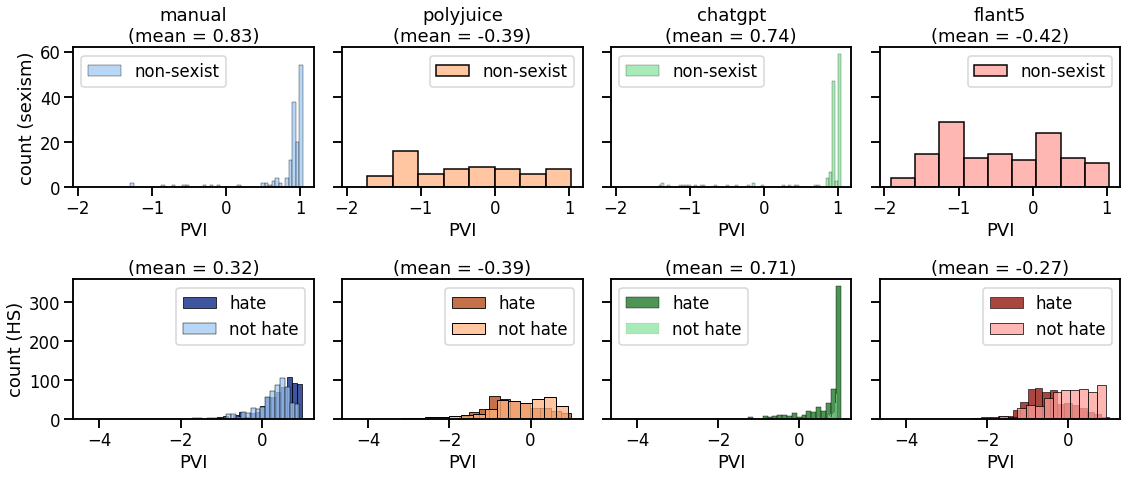

In [126]:
# sns.displot(data = pvi_info['hatespeech'], x = 'PVI', hue = 'mixed_cad_type',  multiple="stack")

fig, ax = plt.subplots(nrows=2, ncols=4,
                        figsize = (16, 7),
                        sharex = 'row',
                        sharey = 'row'
                       )

cad_types = ['counterfactual', 'polyjuice', 'chatgpt', 'flant5']

for n, construct in enumerate(constructs):
    data = pvi_info[construct]
    for m, cad in enumerate(cad_types):
        data_ = data[data['mixed_cad_type'] == cad]
        data_ = data_[data['mixed_cad_label'] == pos_labels[construct]]
        sns.histplot(data_['PVI'], label = pos_labels[construct], 
                     ax = ax[n][m], color = palette1[m])
        data_ = data[data['mixed_cad_type'] == cad]
        data_ = data_[data['mixed_cad_label'] == neg_labels[construct]]
        sns.histplot(data_['PVI'],
                     ax = ax[n][m], color = palette2[m], label = neg_labels[construct])
        if n == 0:
            if cad == 'counterfactual':
                cad_ = 'manual'
            else:
                cad_ = cad
                
            ax[n][m].set_title(cad_ + '\n(mean = %0.2f)' %data[data['mixed_cad_type'] == cad]['PVI'].mean())
        else:
            ax[n][m].set_title('(mean = %0.2f)' %data[data['mixed_cad_type'] == cad]['PVI'].mean())
        # ax[n][m].set_title(cad + '\n(median = %0.2f)' %data[data['mixed_cad_type'] == cad]['PVI'].median())
        ax[n][m].legend()
    
ax[0][0].set_ylabel('count (sexism)')
ax[1][0].set_ylabel('count (HS)')

plt.tight_layout()
# plt.savefig('../results/figures/rq3_datatype_vinfo_dists_app.pdf')

### regression time

Each training instance has the following properties:

- Edit distance [continuous]
- Type of edit [categorical —> negation, affect, identity, gender]
- SBERT sim with original [continuous]
- Label [categorical —> sexist/hateful or non-sexist/non-hateful]
- Source of CAD [categorical —> not cad, manual, polyjuice, chatgpt, flant5]


- ``Grammatical fluency [continuous]``
- ``Coherence [continuous]``
- ``CAD or not? [categorical]``

V-information [continuous] [Dependent variable]

Fit linear regression, expect high R2, interpret beta coefficients

In [127]:
cols = pvi_info[construct].columns
print([col for col in cols if 'mixed_cad' in col])

['mixed_cad_text', 'mixed_cad_label', 'original-mixed_cad', 'original_mixed_cad_ed', 'mixed_cadnegation_additions', 'mixed_cadnegation_deletions', 'mixed_cadaffect word_additions', 'mixed_cadaffect word_deletions', 'mixed_cadgender word_additions', 'mixed_cadgender word_deletions', 'mixed_cadidentity word_additions', 'mixed_cadidentity word_deletions', 'mixed_cad_type']


# hate speech

In [128]:
construct = 'hatespeech'
pvi_regression_data[construct] = pvi_info[construct][['original_mixed_cad_ed', 'original-mixed_cs', 'mixed_cad_label',
                                           'mixed_cad_type', 'PVI', 
                                          'mixed_cadidentity word_deletions','mixed_cadidentity word_additions',
                                           'mixed_cadnegation_additions', 'mixed_cadnegation_deletions',
                                           'mixed_cadaffect word_additions', 'mixed_cadaffect word_deletions',
                                          'mixed_cadgender word_deletions', 'mixed_cadgender word_additions'
                                          ]].fillna(0)#.corr()
for i in ['mixed_cadnegation_additions', 'mixed_cadnegation_deletions',
                                           'mixed_cadaffect word_additions', 'mixed_cadaffect word_deletions',
    'mixed_cadidentity word_deletions', 'mixed_cadidentity word_additions', 
    'mixed_cadgender word_deletions', 'mixed_cadgender word_additions'
         ]:
    pvi_regression_data[construct][i] = [1 if i else 0 for i in pvi_regression_data[construct][i]]
pvi_regression_data[construct]#.isna().sum().head()

,original_mixed_cad_ed,original-mixed_cs,mixed_cad_label,mixed_cad_type,PVI,mixed_cadidentity word_deletions,mixed_cadidentity word_additions,mixed_cadnegation_additions,mixed_cadnegation_deletions,mixed_cadaffect word_additions,mixed_cadaffect word_deletions,mixed_cadgender word_deletions,mixed_cadgender word_additions
0,11.0,0.278779,not hate,chatgpt,0.930909,0,0,0,0,1,1,0,0
1,1.0,0.936871,not hate,polyjuice,-0.594845,0,0,0,0,0,0,0,0
2,1.0,0.892045,not hate,polyjuice,-0.772378,0,0,0,0,1,0,0,0
3,2.0,0.426872,not hate,polyjuice,0.780844,0,0,0,0,1,1,0,0
4,2.0,0.850464,hate,polyjuice,0.636125,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4601,9.0,0.628792,hate,counterfactual,-0.074027,0,0,0,0,0,0,0,0
4602,1.0,0.865793,hate,polyjuice,-0.718727,0,0,0,0,1,1,0,0
4603,7.0,0.815225,not hate,counterfactual,-3.391516,0,0,1,0,1,0,0,0
4604,1.0,0.856641,hate,polyjuice,-1.807738,0,0,0,0,0,0,0,0


In [129]:
### encode the categorical variables
pvi_regression_data[construct] = pd.concat([pvi_regression_data[construct],
                                 pd.get_dummies(pvi_regression_data[construct][['mixed_cad_label', 'mixed_cad_type']])],
                                axis = 1)
pvi_regression_data[construct] = pvi_regression_data[construct].rename({'mixed_cad_label_%s' %pos_labels[construct]: 'mixed_cad_label_hate/sexist',
                                                  'mixed_cad_label_%s' %neg_labels[construct]: 'mixed_cad_label_nothate/notsexist'}, axis=1)  # new method
pvi_regression_data[construct].head()

,original_mixed_cad_ed,original-mixed_cs,mixed_cad_label,mixed_cad_type,PVI,mixed_cadidentity word_deletions,mixed_cadidentity word_additions,mixed_cadnegation_additions,mixed_cadnegation_deletions,mixed_cadaffect word_additions,mixed_cadaffect word_deletions,mixed_cadgender word_deletions,mixed_cadgender word_additions,mixed_cad_label_hate/sexist,mixed_cad_label_nothate/notsexist,mixed_cad_type_chatgpt,mixed_cad_type_counterfactual,mixed_cad_type_flant5,mixed_cad_type_polyjuice
0,11.0,0.278779,not hate,chatgpt,0.930909,0,0,0,0,1,1,0,0,0,1,1,0,0,0
1,1.0,0.936871,not hate,polyjuice,-0.594845,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,1.0,0.892045,not hate,polyjuice,-0.772378,0,0,0,0,1,0,0,0,0,1,0,0,0,1
3,2.0,0.426872,not hate,polyjuice,0.780844,0,0,0,0,1,1,0,0,0,1,0,0,0,1
4,2.0,0.850464,hate,polyjuice,0.636125,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [130]:
pvi_regression_data[construct].columns

Index(['original_mixed_cad_ed', 'original-mixed_cs', 'mixed_cad_label',
       'mixed_cad_type', 'PVI', 'mixed_cadidentity word_deletions',
       'mixed_cadidentity word_additions', 'mixed_cadnegation_additions',
       'mixed_cadnegation_deletions', 'mixed_cadaffect word_additions',
       'mixed_cadaffect word_deletions', 'mixed_cadgender word_deletions',
       'mixed_cadgender word_additions', 'mixed_cad_label_hate/sexist',
       'mixed_cad_label_nothate/notsexist', 'mixed_cad_type_chatgpt',
       'mixed_cad_type_counterfactual', 'mixed_cad_type_flant5',
       'mixed_cad_type_polyjuice'],
      dtype='object')

In [131]:
from stargazer.stargazer import Stargazer
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [132]:
def regress(data, evs, dv):
    Y = data[dv]
    X = sm.add_constant(data[evs])
    model = sm.OLS(Y,X)
    results = model.fit()
    return results

def log_var(data, var):
    logged_data = np.log(data[var])
    return logged_data

def scale_var(data, var):
    scaled_data = [i[0]*1 for i in list(scaler.fit_transform(data[[var]]))]
    return scaled_data

In [133]:
vars_of_interest = ['original_mixed_cad_ed', 'original-mixed_cs', 'PVI']

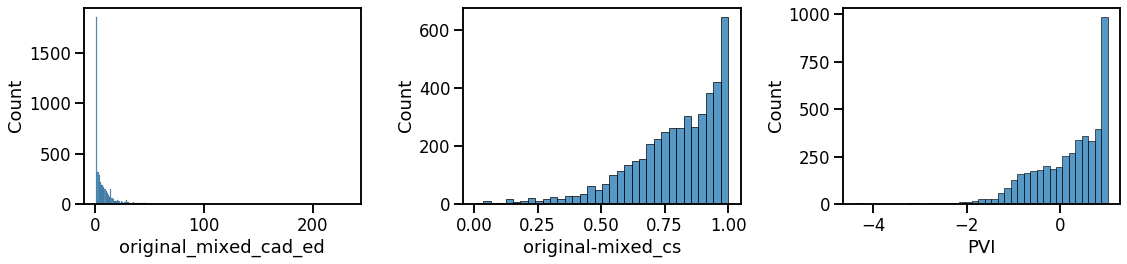

In [134]:
fig, ax = plt.subplots(nrows=1, ncols=3,
                        figsize = (16, 4)
                       )

for n, var_of_interest in enumerate(vars_of_interest):
    sns.histplot(pvi_regression_data[construct][var_of_interest], ax = ax[n])
    
plt.tight_layout()

In [135]:
ed_cs_vars = ['original_mixed_cad_ed', 'original-mixed_cs']

if construct == 'sexism': # for sexism, does it make any sense to add this? it is always 1?
    label_vars = []#['mixed_cad_label_nothate/notsexist']
else:
    label_vars = ['mixed_cad_label_hate/sexist']# ['mixed_cad_label_hate/sexist', 'mixed_cad_label_nothate/notsexist']

cad_vars = ['mixed_cad_type_chatgpt',
                            'mixed_cad_type_counterfactual', 'mixed_cad_type_flant5', 'mixed_cad_type_polyjuice']
edit_vars = [
    'mixed_cadnegation_additions', 'mixed_cadnegation_deletions',
    'mixed_cadaffect word_additions', 'mixed_cadaffect word_deletions',
    'mixed_cadidentity word_deletions', 'mixed_cadidentity word_additions', 
    'mixed_cadgender word_deletions','mixed_cadgender word_additions'
            ]
all_vars = ed_cs_vars + label_vars + cad_vars + edit_vars + ['PVI']

In [136]:
for var_of_interest in all_vars:
    pvi_regression_data[construct][var_of_interest+'_logged'] = log_var(pvi_regression_data[construct],
                                                                        var_of_interest)
    pvi_regression_data[construct][var_of_interest+'_scaled'] = scale_var(pvi_regression_data[construct],
                                                                          var_of_interest)
    pvi_regression_data[construct][var_of_interest+'_scaled_logged'] = log_var(pvi_regression_data[construct],
                                                                               var_of_interest + '_scaled')

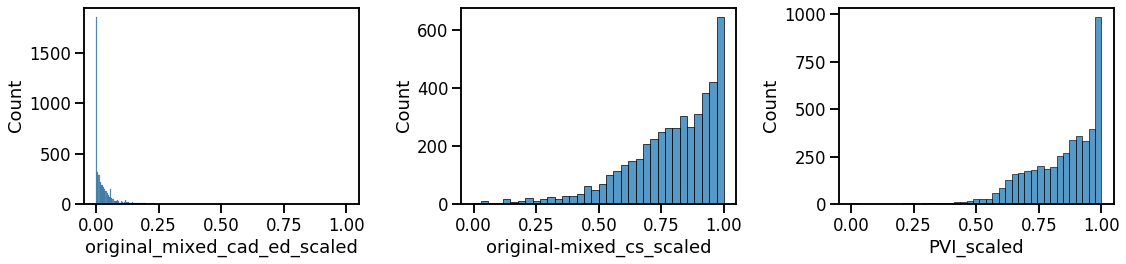

In [137]:
fig, ax = plt.subplots(nrows=1, ncols=3,
                        figsize = (16, 4)
                       )

for n, var_of_interest in enumerate(vars_of_interest):
    sns.histplot(pvi_regression_data[construct][var_of_interest+'_scaled'], ax = ax[n])
    
plt.tight_layout()

In [138]:
ed_cs_label_var = ed_cs_vars + label_vars
ed_cs_label_cad_var = ed_cs_vars + label_vars + cad_vars
ed_cs_label_cad_edit_var = ed_cs_vars + label_vars + edit_vars + cad_vars

In [139]:
first_model = regress(pvi_regression_data[construct], evs = ed_cs_vars, dv = 'PVI')
second_model = regress(pvi_regression_data[construct], evs = [var + '_scaled' for var in ed_cs_vars], dv = 'PVI_scaled')
third_model = regress(pvi_regression_data[construct], evs = ed_cs_label_var, dv = 'PVI')
fourth_model = regress(pvi_regression_data[construct], evs = ed_cs_label_cad_var, dv = 'PVI')
fifth_model = regress(pvi_regression_data[construct], evs = ed_cs_label_cad_edit_var, dv = 'PVI')

In [140]:
dfoutput = summary_col([first_model, third_model, fourth_model, fifth_model],stars=True)
print(dfoutput)


                                   PVI I      PVI II    PVI III    PVI IIII 
----------------------------------------------------------------------------
R-squared                        0.1146     0.1157     0.3430     0.3498    
R-squared Adj.                   0.1142     0.1151     0.3422     0.3480    
const                            0.8836***  0.8982***  0.2673***  0.2173*** 
                                 (0.0513)   (0.0516)   (0.0376)   (0.0398)  
mixed_cad_label_hate/sexist                 -0.0506**  -0.1466*** -0.1631***
                                            (0.0213)   (0.0185)   (0.0190)  
mixed_cad_type_chatgpt                                 0.6893***  0.6432*** 
                                                       (0.0183)   (0.0207)  
mixed_cad_type_counterfactual                          0.2837***  0.2648*** 
                                                       (0.0163)   (0.0167)  
mixed_cad_type_flant5                                  -0.2935*** -0.2887**

In [141]:
Stargazer([first_model, third_model, fourth_model, fifth_model])

In [142]:
print(Stargazer([first_model, fourth_model, fifth_model]).render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable:}} \
\cr \cline{3-4}
\\[-1.8ex] & (1) & (2) & (3) \\
\hline \\[-1.8ex]
 const & 0.884$^{***}$ & 0.267$^{***}$ & 0.217$^{***}$ \\
  & (0.051) & (0.038) & (0.040) \\
 mixed_cad_label_hate/sexist & & -0.147$^{***}$ & -0.163$^{***}$ \\
  & & (0.019) & (0.019) \\
 mixed_cad_type_chatgpt & & 0.689$^{***}$ & 0.643$^{***}$ \\
  & & (0.018) & (0.021) \\
 mixed_cad_type_counterfactual & & 0.284$^{***}$ & 0.265$^{***}$ \\
  & & (0.016) & (0.017) \\
 mixed_cad_type_flant5 & & -0.293$^{***}$ & -0.289$^{***}$ \\
  & & (0.021) & (0.021) \\
 mixed_cad_type_polyjuice & & -0.412$^{***}$ & -0.402$^{***}$ \\
  & & (0.023) & (0.023) \\
 mixed_cadaffect word_additions & & & 0.077$^{***}$ \\
  & & & (0.022) \\
 mixed_cadaffect word_deletions & & & 0.051$^{**}$ \\
  & & & (0.022) \\
 mixed_cadgender word_additions & & & 0.023$^{}$ \\
  & & & (0.034) \\
 m

In [143]:
# pvi_regression_data.to_csv('../results/intermediate/%s_pvi_regression_vars.csv' %construct, sep = '\t')

# sexism

In [144]:
construct = 'sexism'
pvi_regression_data[construct] = pvi_info[construct][['original_mixed_cad_ed', 'original-mixed_cs', 'mixed_cad_label',
                                           'mixed_cad_type', 'PVI', 
                                          'mixed_cadidentity word_deletions','mixed_cadidentity word_additions',
                                           'mixed_cadnegation_additions', 'mixed_cadnegation_deletions',
                                           'mixed_cadaffect word_additions', 'mixed_cadaffect word_deletions',
                                          'mixed_cadgender word_deletions', 'mixed_cadgender word_additions'
                                          ]].fillna(0)#.corr()
for i in ['mixed_cadnegation_additions', 'mixed_cadnegation_deletions',
                                           'mixed_cadaffect word_additions', 'mixed_cadaffect word_deletions',
    'mixed_cadidentity word_deletions', 'mixed_cadidentity word_additions', 
    'mixed_cadgender word_deletions', 'mixed_cadgender word_additions'
         ]:
    pvi_regression_data[construct][i] = [1 if i else 0 for i in pvi_regression_data[construct][i]]
pvi_regression_data[construct]#.isna().sum().head()

,original_mixed_cad_ed,original-mixed_cs,mixed_cad_label,mixed_cad_type,PVI,mixed_cadidentity word_deletions,mixed_cadidentity word_additions,mixed_cadnegation_additions,mixed_cadnegation_deletions,mixed_cadaffect word_additions,mixed_cadaffect word_deletions,mixed_cadgender word_deletions,mixed_cadgender word_additions
0,2.0,0.892890,non-sexist,counterfactual,0.888236,0,0,0,0,0,0,0,0
1,6.0,0.794682,non-sexist,chatgpt,0.941224,1,0,0,0,0,0,1,0
2,1.0,0.726131,non-sexist,flant5,0.305931,0,0,0,0,0,0,0,0
3,3.0,0.836143,non-sexist,counterfactual,0.936297,1,0,0,0,0,0,1,0
4,8.0,0.250247,non-sexist,chatgpt,1.024381,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,4.0,0.771768,non-sexist,counterfactual,0.992572,1,1,0,0,0,0,1,0
494,10.0,0.853667,non-sexist,chatgpt,-0.027484,0,0,0,1,0,0,0,0
495,1.0,0.933793,non-sexist,flant5,0.251042,0,0,0,0,0,0,0,0
496,2.0,0.862299,non-sexist,counterfactual,0.655573,0,0,0,0,0,0,0,0


In [145]:
### encode the categorical variables
pvi_regression_data[construct] = pd.concat([pvi_regression_data[construct],
                                 pd.get_dummies(pvi_regression_data[construct][['mixed_cad_label', 'mixed_cad_type']])],
                                axis = 1)
pvi_regression_data[construct] = pvi_regression_data[construct].rename({'mixed_cad_label_%s' %pos_labels[construct]: 'mixed_cad_label_hate/sexist',
                                                  'mixed_cad_label_%s' %neg_labels[construct]: 'mixed_cad_label_nothate/notsexist'}, axis=1)  # new method
pvi_regression_data[construct].head()

,original_mixed_cad_ed,original-mixed_cs,mixed_cad_label,mixed_cad_type,PVI,mixed_cadidentity word_deletions,mixed_cadidentity word_additions,mixed_cadnegation_additions,mixed_cadnegation_deletions,mixed_cadaffect word_additions,mixed_cadaffect word_deletions,mixed_cadgender word_deletions,mixed_cadgender word_additions,mixed_cad_label_nothate/notsexist,mixed_cad_type_chatgpt,mixed_cad_type_counterfactual,mixed_cad_type_flant5,mixed_cad_type_polyjuice
0,2.0,0.892890,non-sexist,counterfactual,0.888236,0,0,0,0,0,0,0,0,1,0,1,0,0
1,6.0,0.794682,non-sexist,chatgpt,0.941224,1,0,0,0,0,0,1,0,1,1,0,0,0
2,1.0,0.726131,non-sexist,flant5,0.305931,0,0,0,0,0,0,0,0,1,0,0,1,0
3,3.0,0.836143,non-sexist,counterfactual,0.936297,1,0,0,0,0,0,1,0,1,0,1,0,0
4,8.0,0.250247,non-sexist,chatgpt,1.024381,0,0,0,0,0,1,0,0,1,1,0,0,0


In [146]:
pvi_regression_data[construct].columns

Index(['original_mixed_cad_ed', 'original-mixed_cs', 'mixed_cad_label',
       'mixed_cad_type', 'PVI', 'mixed_cadidentity word_deletions',
       'mixed_cadidentity word_additions', 'mixed_cadnegation_additions',
       'mixed_cadnegation_deletions', 'mixed_cadaffect word_additions',
       'mixed_cadaffect word_deletions', 'mixed_cadgender word_deletions',
       'mixed_cadgender word_additions', 'mixed_cad_label_nothate/notsexist',
       'mixed_cad_type_chatgpt', 'mixed_cad_type_counterfactual',
       'mixed_cad_type_flant5', 'mixed_cad_type_polyjuice'],
      dtype='object')

In [147]:
from stargazer.stargazer import Stargazer
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [148]:
def regress(data, evs, dv):
    Y = data[dv]
    X = sm.add_constant(data[evs])
    model = sm.OLS(Y,X)
    results = model.fit()
    return results

def log_var(data, var):
    logged_data = np.log(data[var])
    return logged_data

def scale_var(data, var):
    scaled_data = [i[0]*1 for i in list(scaler.fit_transform(data[[var]]))]
    return scaled_data

In [149]:
vars_of_interest = ['original_mixed_cad_ed', 'original-mixed_cs', 'PVI']

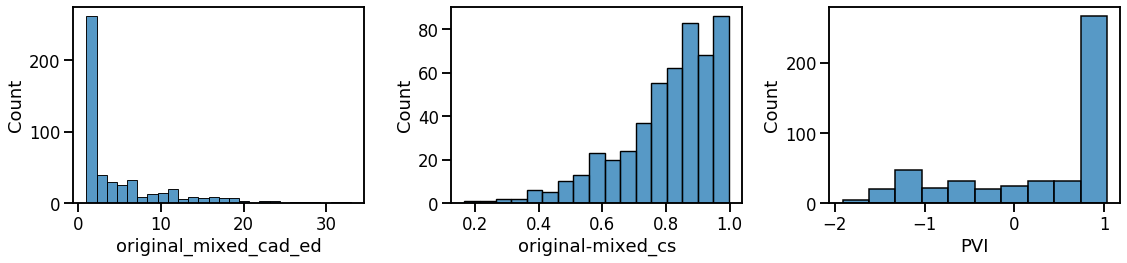

In [150]:
fig, ax = plt.subplots(nrows=1, ncols=3,
                        figsize = (16, 4)
                       )

for n, var_of_interest in enumerate(vars_of_interest):
    sns.histplot(pvi_regression_data[construct][var_of_interest], ax = ax[n])
    
plt.tight_layout()

In [151]:
ed_cs_vars = ['original_mixed_cad_ed', 'original-mixed_cs']

if construct == 'sexism': # for sexism, does it make any sense to add this? it is always 1?
    label_vars = []#['mixed_cad_label_nothate/notsexist']
else:
    label_vars = ['mixed_cad_label_hate/sexist']# ['mixed_cad_label_hate/sexist', 'mixed_cad_label_nothate/notsexist']

cad_vars = ['mixed_cad_type_chatgpt',
                            'mixed_cad_type_counterfactual', 'mixed_cad_type_flant5', 'mixed_cad_type_polyjuice']
edit_vars = [
    'mixed_cadnegation_additions', 'mixed_cadnegation_deletions',
    'mixed_cadaffect word_additions', 'mixed_cadaffect word_deletions',
    'mixed_cadidentity word_deletions', 'mixed_cadidentity word_additions', 
    'mixed_cadgender word_deletions','mixed_cadgender word_additions'
            ]
all_vars = ed_cs_vars + label_vars + cad_vars + edit_vars + ['PVI']

In [152]:
for var_of_interest in all_vars:
    pvi_regression_data[construct][var_of_interest+'_logged'] = log_var(pvi_regression_data[construct],
                                                                        var_of_interest)
    pvi_regression_data[construct][var_of_interest+'_scaled'] = scale_var(pvi_regression_data[construct],
                                                                          var_of_interest)
    pvi_regression_data[construct][var_of_interest+'_scaled_logged'] = log_var(pvi_regression_data[construct],
                                                                               var_of_interest + '_scaled')

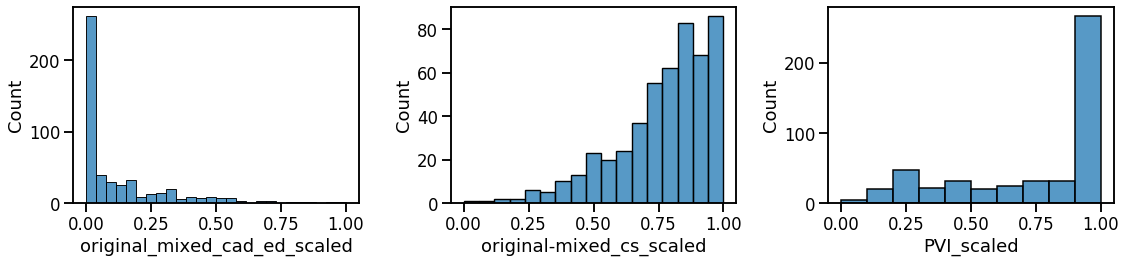

In [153]:
fig, ax = plt.subplots(nrows=1, ncols=3,
                        figsize = (16, 4)
                       )

for n, var_of_interest in enumerate(vars_of_interest):
    sns.histplot(pvi_regression_data[construct][var_of_interest+'_scaled'], ax = ax[n])
    
plt.tight_layout()

In [154]:
ed_cs_label_var = ed_cs_vars + label_vars
ed_cs_label_cad_var = ed_cs_vars + label_vars + cad_vars
ed_cs_label_cad_edit_var = ed_cs_vars + label_vars + edit_vars + cad_vars

In [155]:
first_model = regress(pvi_regression_data[construct], evs = ed_cs_vars, dv = 'PVI')
second_model = regress(pvi_regression_data[construct], evs = [var + '_scaled' for var in ed_cs_vars], dv = 'PVI_scaled')
third_model = regress(pvi_regression_data[construct], evs = ed_cs_label_var, dv = 'PVI')
fourth_model = regress(pvi_regression_data[construct], evs = ed_cs_label_cad_var, dv = 'PVI')
fifth_model = regress(pvi_regression_data[construct], evs = ed_cs_label_cad_edit_var, dv = 'PVI')

In [156]:
dfoutput = summary_col([first_model, third_model, fourth_model, fifth_model],stars=True)
print(dfoutput)


                                   PVI I      PVI II    PVI III    PVI IIII 
----------------------------------------------------------------------------
R-squared                        0.1597     0.1597     0.4856     0.5488    
R-squared Adj.                   0.1563     0.1563     0.4804     0.5376    
const                            2.3306***  2.3306***  1.0425***  0.8614*** 
                                 (0.2921)   (0.2921)   (0.1895)   (0.1905)  
mixed_cad_type_chatgpt                                 0.7961***  0.6225*** 
                                                       (0.0813)   (0.0845)  
mixed_cad_type_counterfactual                          0.8607***  0.6305*** 
                                                       (0.0613)   (0.0693)  
mixed_cad_type_flant5                                  -0.3038*** -0.1906** 
                                                       (0.0767)   (0.0753)  
mixed_cad_type_polyjuice                               -0.3105*** -0.2011**

In [157]:
Stargazer([first_model, third_model, fourth_model, fifth_model])

In [158]:
print(Stargazer([first_model, fourth_model, fifth_model]).render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable:}} \
\cr \cline{3-4}
\\[-1.8ex] & (1) & (2) & (3) \\
\hline \\[-1.8ex]
 const & 2.331$^{***}$ & 1.043$^{***}$ & 0.861$^{***}$ \\
  & (0.292) & (0.190) & (0.190) \\
 mixed_cad_type_chatgpt & & 0.796$^{***}$ & 0.622$^{***}$ \\
  & & (0.081) & (0.085) \\
 mixed_cad_type_counterfactual & & 0.861$^{***}$ & 0.631$^{***}$ \\
  & & (0.061) & (0.069) \\
 mixed_cad_type_flant5 & & -0.304$^{***}$ & -0.191$^{**}$ \\
  & & (0.077) & (0.075) \\
 mixed_cad_type_polyjuice & & -0.311$^{***}$ & -0.201$^{**}$ \\
  & & (0.083) & (0.082) \\
 mixed_cadaffect word_additions & & & 0.064$^{}$ \\
  & & & (0.077) \\
 mixed_cadaffect word_deletions & & & -0.213$^{***}$ \\
  & & & (0.077) \\
 mixed_cadgender word_additions & & & -0.601$^{***}$ \\
  & & & (0.095) \\
 mixed_cadgender word_deletions & & & 0.186$^{***}$ \\
  & & & (0.036) \\
 mixed_cadidentity wor

### with interactions using Mattia's code

In [159]:
df = pvi_regression_data['hatespeech']
df

,original_mixed_cad_ed,original-mixed_cs,mixed_cad_label,mixed_cad_type,PVI,mixed_cadidentity word_deletions,mixed_cadidentity word_additions,mixed_cadnegation_additions,mixed_cadnegation_deletions,mixed_cadaffect word_additions,mixed_cadaffect word_deletions,mixed_cadgender word_deletions,mixed_cadgender word_additions,mixed_cad_label_hate/sexist,mixed_cad_label_nothate/notsexist,mixed_cad_type_chatgpt,mixed_cad_type_counterfactual,mixed_cad_type_flant5,mixed_cad_type_polyjuice,original_mixed_cad_ed_logged,original_mixed_cad_ed_scaled,original_mixed_cad_ed_scaled_logged,original-mixed_cs_logged,original-mixed_cs_scaled,original-mixed_cs_scaled_logged,mixed_cad_label_hate/sexist_logged,mixed_cad_label_hate/sexist_scaled,mixed_cad_label_hate/sexist_scaled_logged,mixed_cad_type_chatgpt_logged,mixed_cad_type_chatgpt_scaled,mixed_cad_type_chatgpt_scaled_logged,mixed_cad_type_counterfactual_logged,mixed_cad_type_counterfactual_scaled,mixed_cad_type_counterfactual_scaled_logged,mixed_cad_type_flant5_logged,mixed_cad_type_flant5_scaled,mixed_cad_type_flant5_scaled_logged,mixed_cad_type_polyjuice_logged,mixed_cad_type_polyjuice_scaled,mixed_cad_type_polyjuice_scaled_logged,mixed_cadnegation_additions_logged,mixed_cadnegation_additions_scaled,mixed_cadnegation_additions_scaled_logged,mixed_cadnegation_deletions_logged,mixed_cadnegation_deletions_scaled,mixed_cadnegation_deletions_scaled_logged,mixed_cadaffect word_additions_logged,mixed_cadaffect word_additions_scaled,mixed_cadaffect word_additions_scaled_logged,mixed_cadaffect word_deletions_logged,mixed_cadaffect word_deletions_scaled,mixed_cadaffect word_deletions_scaled_logged,mixed_cadidentity word_deletions_logged,mixed_cadidentity word_deletions_scaled,mixed_cadidentity word_deletions_scaled_logged,mixed_cadidentity word_additions_logged,mixed_cadidentity word_additions_scaled,mixed_cadidentity word_additions_scaled_logged,mixed_cadgender word_deletions_logged,mixed_cadgender word_deletions_scaled,mixed_cadgender word_deletions_scaled_logged,mixed_cadgender word_additions_logged,mixed_cadgender word_additions_scaled,mixed_cadgender word_additions_scaled_logged,PVI_logged,PVI_scaled,PVI_scaled_logged
0,11.0,0.278779,not hate,chatgpt,0.930909,0,0,0,0,1,1,0,0,0,1,1,0,0,0,2.397895,0.043103,-3.144152,-1.277338,0.273878,-1.295073,-inf,0.0,-inf,0.0,1.0,0.0,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,0.0,1.0,0.0,0.0,1.0,0.0,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-0.071594,0.985147,-0.014964
1,1.0,0.936871,not hate,polyjuice,-0.594845,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.000000,0.000000,-inf,-0.065209,0.936662,-0.065433,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,0.0,1.0,0.0,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,NaN,0.701915,-0.353943
2,1.0,0.892045,not hate,polyjuice,-0.772378,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.000000,-inf,-0.114239,0.891516,-0.114832,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,0.0,1.0,0.0,-inf,0.0,-inf,-inf,0.0,-inf,0.0,1.0,0.0,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,NaN,0.668958,-0.402033
3,2.0,0.426872,not hate,polyjuice,0.780844,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0.693147,0.004310,-5.446737,-0.851271,0.423027,-0.860319,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,0.0,1.0,0.0,-inf,0.0,-inf,-inf,0.0,-inf,0.0,1.0,0.0,0.0,1.0,0.0,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-0.247380,0.957290,-0.043649
4,2.0,0.850464,hate,polyjuice,0.636125,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.693147,0.004310,-5.446737,-0.161973,0.849639,-0.162944,0.0,1.0,0.0,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,0.0,1.0,0.0,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-inf,0.0,-inf,-0.452360,0.930425,-0.072114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [160]:
df, transformed_df = transform_df(df.copy())
transformed_df.head()

,edit_distance,cosine_similarity,cad_type,pvi,identity_word_del,identity_word_add,affect_word_del,affect_word_add,negation_del,negation_add,gender_word_del,gender_word_add,cad_label
0,1,0,chatgpt,1.841648,0,0,1,1,0,0,0,0,0
1,0,1,polyjuice,1.564685,0,0,0,0,0,0,0,0,0
2,0,1,polyjuice,1.526846,0,0,0,1,0,0,0,0,0
3,0,0,polyjuice,1.817566,0,0,1,1,0,0,0,0,0
4,0,1,polyjuice,1.793780,0,0,0,0,0,0,0,0,1


In [161]:
df[['original_mixed_cad_ed', 'original_minus_mixed_cs',
             'mixed_cad_type', 'PVI', 'mixed_cad_identity_word_deletions',
             'mixed_cad_identity_word_additions', 'mixed_cad_negation_additions',
             'mixed_cad_negation_deletions', 'mixed_cad_affect_word_additions',
             'mixed_cad_affect_word_deletions', 'mixed_cad_gender_word_deletions',
             'mixed_cad_gender_word_additions', 'mixed_cad_label_hate_sexist', ]].describe()

,original_mixed_cad_ed,original_minus_mixed_cs,PVI,mixed_cad_identity_word_deletions,mixed_cad_identity_word_additions,mixed_cad_negation_additions,mixed_cad_negation_deletions,mixed_cad_affect_word_additions,mixed_cad_affect_word_deletions,mixed_cad_gender_word_deletions,mixed_cad_gender_word_additions,mixed_cad_label_hate_sexist
count,4606.000000,4606.000000,4606.000000,4606.000000,4606.000000,4606.000000,4606.000000,4606.000000,4606.000000,4606.000000,4606.000000,4606.000000
mean,8.470908,0.787726,0.164066,0.108337,0.076856,0.123969,0.092054,0.467434,0.384281,0.108337,0.090100,0.500000
std,12.817550,0.182435,0.758874,0.310839,0.266392,0.329582,0.289133,0.498992,0.486478,0.310839,0.286356,0.500054
min,1.000000,0.006839,-4.376013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.690403,-0.333465,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,0.827417,0.369643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
75%,10.000000,0.935021,0.820466,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,233.000000,0.999761,1.010921,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [162]:
transformed_df.describe()

,edit_distance,cosine_similarity,pvi,identity_word_del,identity_word_add,affect_word_del,affect_word_add,negation_del,negation_add,gender_word_del,gender_word_add,cad_label
count,4606.000000,4606.000000,4606.000000,4606.000000,4606.000000,4606.000000,4606.000000,4606.000000,4606.000000,4606.000000,4606.000000,4606.000000
mean,0.465046,0.500000,1.700799,0.108337,0.076856,0.384281,0.467434,0.092054,0.123969,0.108337,0.090100,0.500000
std,0.498831,0.500054,0.158317,0.310839,0.266392,0.486478,0.498992,0.289133,0.329582,0.310839,0.286356,0.500054
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.617912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.500000,1.748444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
75%,1.000000,1.000000,1.823981,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.854254,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


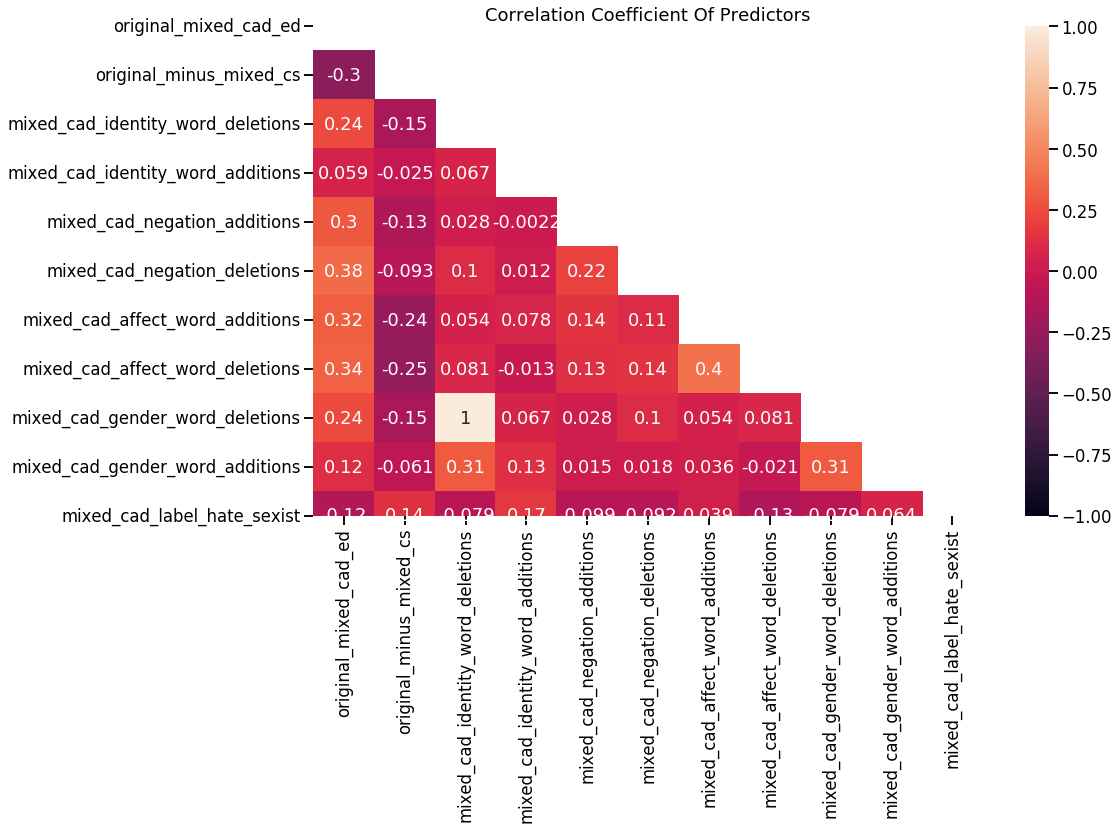

In [163]:
toplot=df[['original_mixed_cad_ed', 'original_minus_mixed_cs',
          'mixed_cad_identity_word_deletions',
         'mixed_cad_identity_word_additions', 'mixed_cad_negation_additions',
         'mixed_cad_negation_deletions', 'mixed_cad_affect_word_additions',
         'mixed_cad_affect_word_deletions', 'mixed_cad_gender_word_deletions',
         'mixed_cad_gender_word_additions', 'mixed_cad_label_hate_sexist', ]]

plot_corr(toplot)

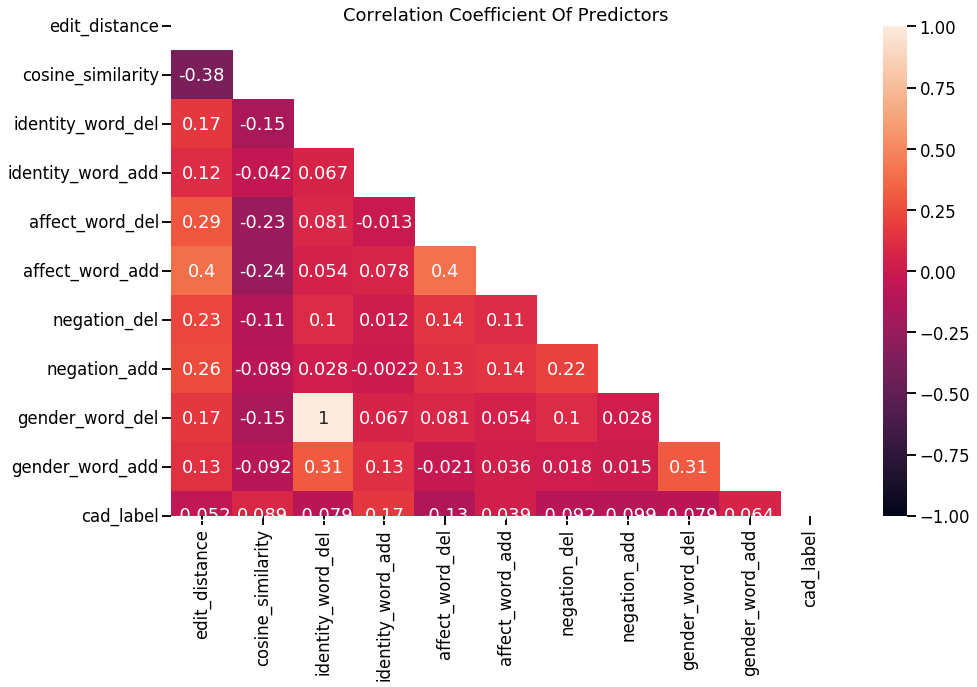

In [164]:
toplot=transformed_df[['edit_distance', 'cosine_similarity',
       'identity_word_del', 'identity_word_add', 'affect_word_del',
       'affect_word_add', 'negation_del', 'negation_add', 'gender_word_del',
       'gender_word_add', 'cad_label']]

plot_corr(toplot)

In [165]:
formula = "pvi ~ C(cad_type, Treatment(reference='counterfactual')) * (edit_distance + cosine_similarity + identity_word_del + identity_word_add + affect_word_del + affect_word_add + negation_del + negation_add + gender_word_add + cad_label)"
formula = "pvi ~ C(cad_type, Treatment(reference='counterfactual')) * (edit_distance + cosine_similarity + identity_word_del + identity_word_add + affect_word_del + affect_word_add + negation_del + negation_add + cad_label)"
mdl = smf.glm(formula = formula,
              data=transformed_df,
              )
res = mdl.fit()

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    pvi   No. Observations:                 4606
Model:                            GLM   Df Residuals:                     4566
Model Family:                Gaussian   Df Model:                           39
Link Function:               identity   Scale:                        0.017413
Method:                          IRLS   Log-Likelihood:                 2812.8
Date:                Fri, 23 Jun 2023   Deviance:                       79.509
Time:                        15:44:40   Pearson chi2:                     79.5
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                                                                        coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

In [166]:
formula = "pvi ~ C(cad_type, Treatment(reference='counterfactual')) + edit_distance + cosine_similarity + identity_word_del + identity_word_add + affect_word_del + affect_word_add + negation_del + negation_add + gender_word_add + cad_label"
formula = "pvi ~ C(cad_type, Treatment(reference='counterfactual')) + edit_distance + cosine_similarity + identity_word_del + identity_word_add + affect_word_del + affect_word_add + negation_del + negation_add + cad_label"
mdl = smf.glm(formula = formula,
              data=transformed_df,
              )
res = mdl.fit()

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    pvi   No. Observations:                 4606
Model:                            GLM   Df Residuals:                     4593
Model Family:                Gaussian   Df Model:                           12
Link Function:               identity   Scale:                        0.018008
Method:                          IRLS   Log-Likelihood:                 2721.9
Date:                Fri, 23 Jun 2023   Deviance:                       82.711
Time:                        15:44:40   Pearson chi2:                     82.7
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [167]:
formula = "pvi ~ C(cad_type, Treatment(reference='counterfactual')) +\
edit_distance + cosine_similarity + cad_label * (identity_word_del + identity_word_add) +\
affect_word_del + affect_word_add +\
negation_del + negation_add"

formula = "pvi ~ C(cad_type, Treatment(reference='counterfactual')) +\
edit_distance + cosine_similarity + cad_label * (identity_word_del + identity_word_add)"

mdl = smf.ols(formula = formula,
              data=transformed_df,
              )
res_hs = mdl.fit()

print(res_hs.summary())

                            OLS Regression Results                            
Dep. Variable:                    pvi   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     184.1
Date:                Fri, 23 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:44:40   Log-Likelihood:                 2730.5
No. Observations:                4606   AIC:                            -5439.
Df Residuals:                    4595   BIC:                            -5368.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

# sexism

In [168]:
df = pvi_regression_data['sexism']
df, transformed_df = transform_df(df.copy())
transformed_df.head()

,edit_distance,cosine_similarity,cad_type,pvi,identity_word_del,identity_word_add,affect_word_del,affect_word_add,negation_del,negation_add,gender_word_del,gender_word_add,cad_label
0,0,1,counterfactual,1.335612,0,0,0,0,0,0,0,0,0
1,1,0,chatgpt,1.349451,1,0,0,0,0,0,1,0,0
2,0,0,flant5,1.169386,0,0,0,0,0,0,0,0,0
3,1,0,counterfactual,1.348172,1,0,0,0,0,0,1,0,0
4,1,0,chatgpt,1.370791,0,0,1,0,0,0,0,0,0


In [169]:
transformed_df.describe()

,edit_distance,cosine_similarity,pvi,identity_word_del,identity_word_add,affect_word_del,affect_word_add,negation_del,negation_add,gender_word_del,gender_word_add,cad_label
count,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.0
mean,0.473896,0.500000,1.120700,0.566265,0.030120,0.216867,0.214859,0.084337,0.086345,0.566265,0.116466,0.0
std,0.499820,0.500503,0.327888,0.496088,0.171091,0.412526,0.411138,0.278173,0.281156,0.496088,0.321105,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.905632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.500000,1.332096,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
75%,1.000000,1.000000,1.355690,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
max,1.000000,1.000000,1.373452,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


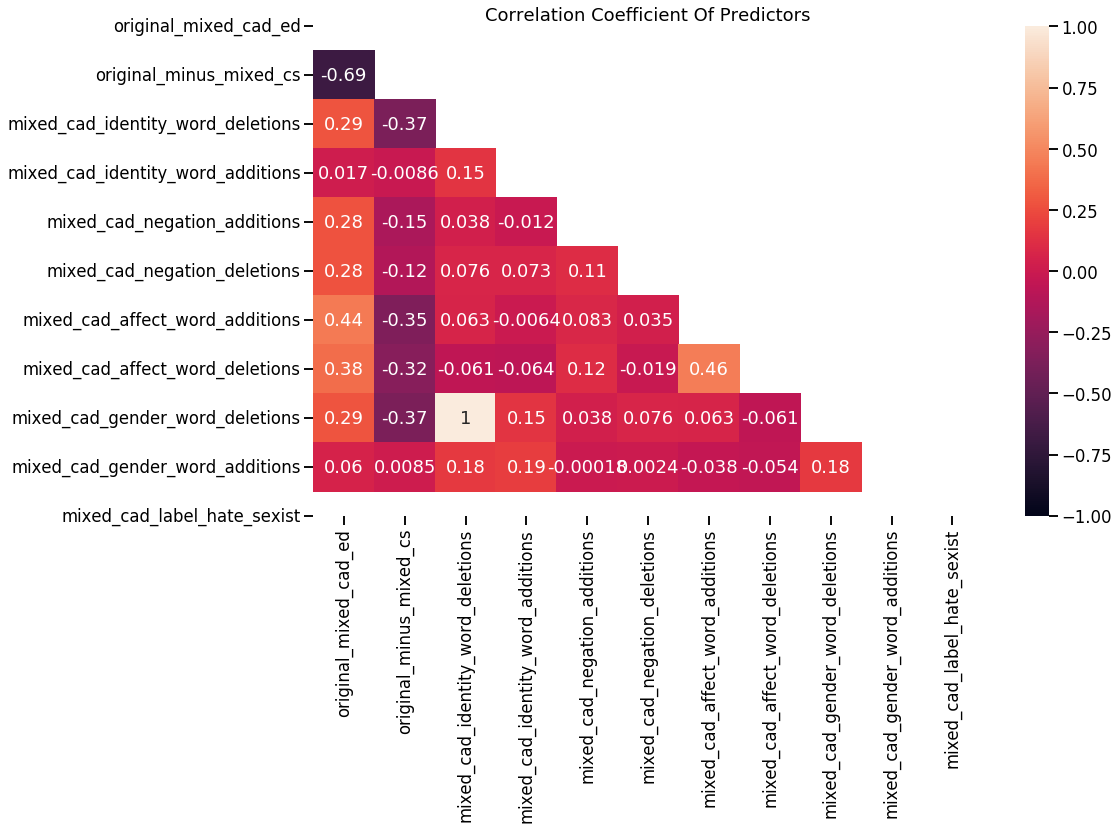

In [170]:
toplot=df[['original_mixed_cad_ed', 'original_minus_mixed_cs',
          'mixed_cad_identity_word_deletions',
         'mixed_cad_identity_word_additions', 'mixed_cad_negation_additions',
         'mixed_cad_negation_deletions', 'mixed_cad_affect_word_additions',
         'mixed_cad_affect_word_deletions', 'mixed_cad_gender_word_deletions',
         'mixed_cad_gender_word_additions', 'mixed_cad_label_hate_sexist', ]]

plot_corr(toplot)

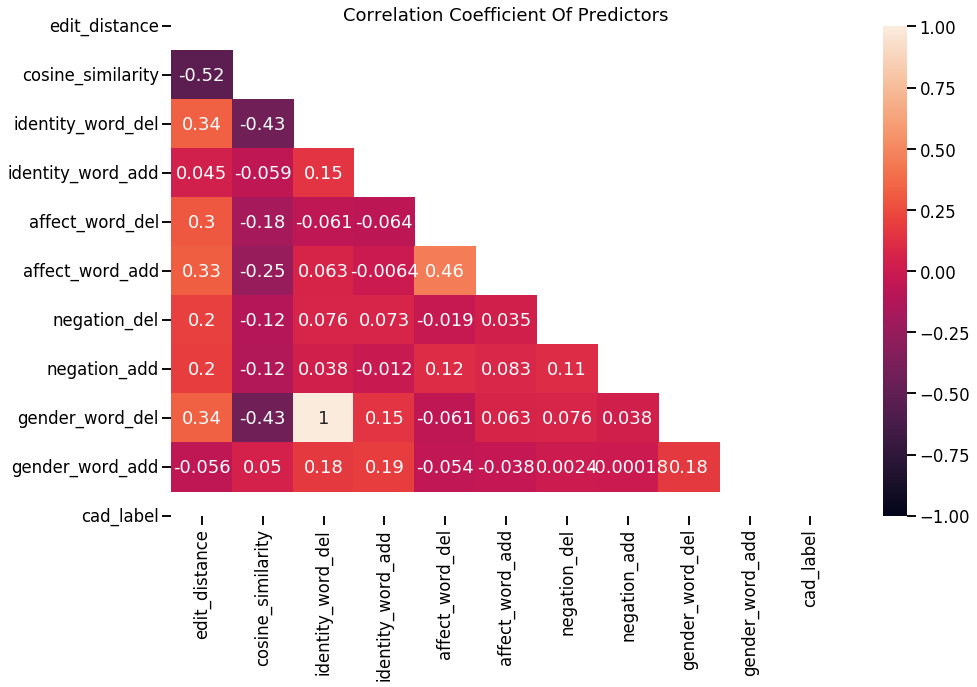

In [171]:
toplot=transformed_df[['edit_distance', 'cosine_similarity',
       'identity_word_del', 'identity_word_add', 'affect_word_del',
       'affect_word_add', 'negation_del', 'negation_add', 'gender_word_del',
       'gender_word_add', 'cad_label']]

plot_corr(toplot)

In [172]:
formula = "pvi ~ C(cad_type, Treatment(reference='counterfactual')) * (edit_distance + cosine_similarity + identity_word_del + identity_word_add + affect_word_del + affect_word_add + negation_del + negation_add + gender_word_add)"
mdl = smf.glm(formula = formula,
              data=transformed_df,
              )
res = mdl.fit()

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    pvi   No. Observations:                  498
Model:                            GLM   Df Residuals:                      459
Model Family:                Gaussian   Df Model:                           38
Link Function:               identity   Scale:                        0.054420
Method:                          IRLS   Log-Likelihood:                 38.520
Date:                Fri, 23 Jun 2023   Deviance:                       24.979
Time:                        15:44:42   Pearson chi2:                     25.0
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                                                                        coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

In [173]:
formula = "pvi ~ C(cad_type, Treatment(reference='counterfactual')) + edit_distance + cosine_similarity + gender_word_del + gender_word_add + affect_word_del + affect_word_add + negation_del + negation_add "
formula = "pvi ~ C(cad_type, Treatment(reference='counterfactual')) + edit_distance + cosine_similarity +\
gender_word_del + gender_word_add"

mdl = smf.ols(formula = formula,
              data=transformed_df,
              )
res_s = mdl.fit()

print(res_s.summary())

                            OLS Regression Results                            
Dep. Variable:                    pvi   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     63.77
Date:                Fri, 23 Jun 2023   Prob (F-statistic):           5.64e-65
Time:                        15:44:42   Log-Likelihood:                 10.437
No. Observations:                 498   AIC:                            -4.874
Df Residuals:                     490   BIC:                             28.81
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [174]:
Stargazer([res_s, res_hs])

In [175]:
print(Stargazer([res_s, res_hs]).render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{2}{c}{\textit{Dependent variable:}} \
\cr \cline{2-3}
\\[-1.8ex] & (1) & (2) \\
\hline \\[-1.8ex]
 C(cad_type, Treatment(reference='counterfactual'))[T.chatgpt] & 0.000$^{}$ & 0.064$^{***}$ \\
  & (0.032) & (0.005) \\
 C(cad_type, Treatment(reference='counterfactual'))[T.flant5] & -0.298$^{***}$ & -0.102$^{***}$ \\
  & (0.035) & (0.006) \\
 C(cad_type, Treatment(reference='counterfactual'))[T.polyjuice] & -0.307$^{***}$ & -0.127$^{***}$ \\
  & (0.042) & (0.007) \\
 Intercept & 1.254$^{***}$ & 1.744$^{***}$ \\
  & (0.037) & (0.006) \\
 cad_label & & -0.034$^{***}$ \\
  & & (0.004) \\
 cad_label:identity_word_add & & 0.099$^{***}$ \\
  & & (0.018) \\
 cad_label:identity_word_del & & -0.017$^{}$ \\
  & & (0.013) \\
 cosine_similarity & -0.071$^{***}$ & -0.010$^{**}$ \\
  & (0.028) & (0.004) \\
 edit_distance & -0.063$^{**}$ & 0.013$^{***}$ \\
  & (0.029) & (0.005) \\


In [176]:
len(pvi_regression_data['sexism']), len(pvi_regression_data['hatespeech'])

(498, 4606)